In [ ]:
# Cell 1
import os, time, copy, math, random, gc
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

CONFIG = {
    # FL
    "num_clients": 10,
    "client_frac": 1.0,
    "rounds": 10,             
    "local_epochs": 5,
    "batch_size": 256,
    "lr": 0.01,
    "dirichlet_alpha": 0.1,

    # Model/Dataset
    "dataset": "fashionmnist",
    "model_type": "resnet18",

    # FedAvgM
    "server_momentum": 0.9,

    # FedSAM baseline
    "fedsam_rho": 0.05,

    # FedLW / FedLWSAM (best-effort baseline)
    "fedlw_use_inv_loss": True,      # weight clients by inverse local loss
    "fedlw_eps": 1e-6,

    # qFedAvg (best-effort baseline)
    "qfedavg_q": 5.0,

    # FedLESAM (best-effort, 1-backward SAM using global-diff direction)
    "fedlesam_rho": 0.05,

    # FedWMSAM (best-effort: server momentum + SAM)
    "fedwmsam_rho": 0.05,
    "fedwmsam_server_momentum": 0.9,

   
    "fedscam_rho_max": 0.05,
    "fedscam_rho_min": 0.01,   # <<< ONLY NEW PARAM (rho floor)
    "fedscam_alpha_rho": 1.0,
    "fedscam_kappa_h": 1.0,
    "fedscam_beta_global": 0.8,
    "fedscam_gamma_weight": 1.0,
    "fedscam_n_clusters": 3,
    "fedscam_downweight_conflict": 0.5,
    "fedscam_summary_dim": 256,  
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Cell 2

FMNIST_MEAN = (0.2860,)
FMNIST_STD  = (0.3530,)

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD),
])

train_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform_train)
test_dataset  = datasets.FashionMNIST("./data", train=False, download=True, transform=transform_test)

def dirichlet_split(dataset, n_clients, alpha=0.1, seed=42):
    rng = np.random.default_rng(seed)
    labels = np.array([dataset[i][1] for i in range(len(dataset))], dtype=np.int64)
    n_classes = labels.max() + 1
    client_idxs = [[] for _ in range(n_clients)]

    for k in range(n_classes):
        idx_k = np.where(labels == k)[0]
        rng.shuffle(idx_k)
        props = rng.dirichlet([alpha] * n_clients)
        props = (props * len(idx_k)).astype(int)
        props[-1] = len(idx_k) - props[:-1].sum()

        ptr = 0
        for i, p in enumerate(props):
            if p > 0:
                client_idxs[i].extend(idx_k[ptr:ptr+p])
            ptr += p

    client_loaders = []
    for idxs in client_idxs:
        if len(idxs) == 0:
            idxs = [0]
        loader = DataLoader(
            Subset(dataset, idxs),
            batch_size=CONFIG["batch_size"],
            shuffle=True,
            num_workers=0,
            pin_memory=False,
        )
        client_loaders.append(loader)
    return client_loaders, client_idxs

client_loaders, client_indices = dirichlet_split(
    train_dataset,
    CONFIG["num_clients"],
    alpha=CONFIG["dirichlet_alpha"],
    seed=SEED
)

test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0, pin_memory=False)

client_sizes = [len(ix) for ix in client_indices]
print("Client sizes:", client_sizes, "| total:", sum(client_sizes))


Client sizes: [6541, 13621, 4622, 1444, 8581, 9969, 2436, 2007, 5873, 4906] | total: 60000


In [3]:
# Cell 3
from torchvision.models import resnet18

class ResNet18_FMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        m = resnet18(weights=None, num_classes=num_classes)
        # 1-channel input, small images
        m.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()
        self.model = m

    def forward(self, x):
        return self.model(x)

def create_model():
    return ResNet18_FMNIST(num_classes=10)

# sanity
_tmp = create_model().to(device)
print("Params:", sum(p.numel() for p in _tmp.parameters()))
del _tmp


Params: 11172810


In [4]:
# Cell 4
def clear_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def state_to_vec(state_dict):
    """
    Vectorize ONLY floating tensors from state_dict (params + float buffers).
    This avoids corrupting integer buffers (e.g., num_batches_tracked) and
    makes projection sizing consistent.
    """
    chunks = []
    for v in state_dict.values():
        if torch.is_tensor(v) and torch.is_floating_point(v):
            chunks.append(v.detach().cpu().to(torch.float32).contiguous().view(-1).numpy())
    if len(chunks) == 0:
        return np.array([], dtype=np.float32)
    return np.concatenate(chunks).astype(np.float32, copy=False)

def vec_to_state(vec, template_state_dict):
    """
    Rebuild a full state_dict:
    - Fill floating tensors from vec (in the same iteration order as state_to_vec)
    - Copy non-floating tensors directly from template (unchanged)
    """
    new = {}
    ptr = 0
    for k, v in template_state_dict.items():
        if torch.is_tensor(v) and torch.is_floating_point(v):
            n = v.numel()
            new_v = torch.from_numpy(vec[ptr:ptr+n].reshape(v.shape)).to(dtype=v.dtype)
            new[k] = new_v
            ptr += n
        else:
            new[k] = v.clone() if torch.is_tensor(v) else v
    return new

def normalize(vec):
    n = np.linalg.norm(vec)
    return vec / (n + 1e-12) if n > 1e-12 else vec

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss_sum += F.cross_entropy(out, y, reduction="sum").item()
        correct += out.argmax(1).eq(y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def pretty_round(method, r, R, loss, acc, dt):
    print(f"[{method:<9}] Round {r:02d}/{R} | loss={loss:.4f} | acc={acc*100:6.2f}% | time={dt:6.2f}s")


In [ ]:
# Cell 5
class SAM:
   
    def __init__(self, params, rho=0.05):
        self.params = list(params)
        self.optimizer = optim.SGD(self.params, lr=CONFIG["lr"])
        self.rho = rho

    def zero_grad(self):
        self.optimizer.zero_grad(set_to_none=True)

    def first_step(self):
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in self.params if p.grad is not None))
        for p in self.params:
            if p.grad is not None:
                eps = self.rho * p.grad / (norm + 1e-12)
                p.data.add_(eps)
                p._eps = eps

    def second_step(self):
        for p in self.params:
            if hasattr(p, "_eps"):
                p.data.sub_(p._eps)
                del p._eps
        self.optimizer.step()


In [6]:
# Cell 6
def fedavg_client(global_state, loader):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = state_to_vec(model.state_dict())

    opt = optim.SGD(model.parameters(), lr=CONFIG["lr"])
    model.train()
    n_samples = 0
    loss_meter = 0.0

    for _ in range(CONFIG["local_epochs"]):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)

            opt.zero_grad(set_to_none=True)
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            opt.step()

            loss_meter += loss.item() * x.size(0)

    after = state_to_vec(model.state_dict())
    delta = after - before
    avg_loss = loss_meter / max(1, n_samples)

    del model, opt, before, after
    clear_mem()
    return delta, n_samples, avg_loss

def aggregate_by_sizes(global_state, deltas, sizes):
    weights = np.array(sizes, dtype=np.float32)
    weights = weights / (weights.sum() + 1e-12)
    agg = np.zeros_like(deltas[0], dtype=np.float32)
    for d, w in zip(deltas, weights):
        agg += d * w
    new_vec = state_to_vec(global_state) + agg
    return vec_to_state(new_vec, global_state)

def run_fedavg():
    method = "FedAvg"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes, local_losses = [], [], []
        for cid in selected:
            d, n, l = fedavg_client(global_state, client_loaders[cid])
            deltas.append(d); sizes.append(n); local_losses.append(l)

        global_state = aggregate_by_sizes(global_state, deltas, sizes)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }

def run_fedavgm():
    method = "FedAvgM"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())
    v = np.zeros_like(state_to_vec(global_state), dtype=np.float32)

    mu = CONFIG["server_momentum"]

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes = [], []
        for cid in selected:
            d, n, _ = fedavg_client(global_state, client_loaders[cid])
            deltas.append(d); sizes.append(n)

        # FedAvg delta
        weights = np.array(sizes, dtype=np.float32)
        weights = weights / (weights.sum() + 1e-12)
        delta = np.zeros_like(deltas[0], dtype=np.float32)
        for d, w in zip(deltas, weights):
            delta += d * w

        # server momentum
        v = mu * v + delta
        new_vec = state_to_vec(global_state) + v
        global_state = vec_to_state(new_vec, global_state)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [7]:
# Cell 7
def fedsam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = state_to_vec(model.state_dict())

    sam = SAM(model.parameters(), rho=rho)
    model.train()
    n_samples = 0
    loss_meter = 0.0

    for _ in range(CONFIG["local_epochs"]):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)

            sam.zero_grad()
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            sam.first_step()

            sam.zero_grad()
            loss2 = F.cross_entropy(model(x), y)
            loss2.backward()
            sam.second_step()

            loss_meter += loss.item() * x.size(0)

    after = state_to_vec(model.state_dict())
    delta = after - before
    avg_loss = loss_meter / max(1, n_samples)

    del model, sam, before, after
    clear_mem()
    return delta, n_samples, avg_loss

def run_fedsam():
    method = "FedSAM"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes = [], []
        for cid in selected:
            d, n, _ = fedsam_client(global_state, client_loaders[cid], CONFIG["fedsam_rho"])
            deltas.append(d); sizes.append(n)

        global_state = aggregate_by_sizes(global_state, deltas, sizes)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [8]:
# Cell 8
def run_fedlw(use_sam=False):
    method = "FedLWSAM" if use_sam else "FedLW"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes, ltrain = [], [], []
        for cid in selected:
            if use_sam:
                d, n, l = fedsam_client(global_state, client_loaders[cid], CONFIG["fedsam_rho"])
            else:
                d, n, l = fedavg_client(global_state, client_loaders[cid])
            deltas.append(d); sizes.append(n); ltrain.append(l)

        # loss-weighted aggregation (best-effort)
        ltrain = np.array(ltrain, dtype=np.float32)
        sizes_arr = np.array(sizes, dtype=np.float32)

        if CONFIG["fedlw_use_inv_loss"]:
            w = sizes_arr / (ltrain + CONFIG["fedlw_eps"])
        else:
            w = sizes_arr * np.exp(-ltrain)

        w = w / (w.sum() + 1e-12)

        agg = np.zeros_like(deltas[0], dtype=np.float32)
        for d, wi in zip(deltas, w):
            agg += d * wi

        new_vec = state_to_vec(global_state) + agg
        global_state = vec_to_state(new_vec, global_state)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({
            "round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt,
            "avg_train_loss": float(ltrain.mean())
        })

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [ ]:
# Cell 9
def run_qfedavg():
    # best-effort: weight client updates by (loss_on_global)^q and re-normalize
    method = "qFedAvg"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    q = float(CONFIG["qfedavg_q"])

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes, loss_on_global = [], [], []
        for cid in selected:
            # loss on current global (clients data)
            tmp = create_model().to(device)
            tmp.load_state_dict(global_state)
            tmp.eval()
            losssum, nsum = 0.0, 0
            with torch.no_grad():
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    out = tmp(x)
                    losssum += F.cross_entropy(out, y, reduction="sum").item()
                    nsum += y.size(0)
                    break  # quick estimate (keeps runtime sane)
            lg = (losssum / max(1, nsum))
            del tmp
            clear_mem()

            # local train (FedAvg-style)
            d, n, _ = fedavg_client(global_state, client_loaders[cid])
            deltas.append(d); sizes.append(n); loss_on_global.append(lg)

        loss_on_global = np.array(loss_on_global, dtype=np.float32)
        sizes_arr = np.array(sizes, dtype=np.float32)

        w = (loss_on_global + 1e-12) ** q
        w = w * sizes_arr
        w = w / (w.sum() + 1e-12)

        agg = np.zeros_like(deltas[0], dtype=np.float32)
        for d, wi in zip(deltas, w):
            agg += d * wi

        new_vec = state_to_vec(global_state) + agg
        global_state = vec_to_state(new_vec, global_state)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({
            "round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt,
            "mean_loss_on_global_est": float(loss_on_global.mean())
        })

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [ ]:
# Cell 10
def fedlesam_client(global_state, loader, rho, global_diff_vec):
    
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = state_to_vec(model.state_dict())

    opt = optim.SGD(model.parameters(), lr=CONFIG["lr"])
    model.train()
    n_samples = 0
    loss_meter = 0.0

    # build perturb once for this client-round
    gdir = normalize(global_diff_vec.astype(np.float32))
    # we need a per-parameter perturb tensor (same for whole round)
    # convert vector perturb into state_dict-shaped tensors
    eps_state = vec_to_state(rho * gdir, model.state_dict())

    for _ in range(CONFIG["local_epochs"]):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)

            # add perturb
            with torch.no_grad():
                for (k, p) in model.state_dict().items():
                    pass
                for name, param in model.named_parameters():
                    # map by state_dict key name (same names for parameters)
                    if name in eps_state:
                        param.data.add_(eps_state[name].to(param.device))

            opt.zero_grad(set_to_none=True)
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()

            # remove perturb then step using grad at perturbed point
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if name in eps_state:
                        param.data.sub_(eps_state[name].to(param.device))
            opt.step()

            loss_meter += loss.item() * x.size(0)

    after = state_to_vec(model.state_dict())
    delta = after - before
    avg_loss = loss_meter / max(1, n_samples)

    del model, opt, before, after, eps_state
    clear_mem()
    return delta, n_samples, avg_loss

def run_fedlesam():
    method = "FedLESAM"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())
    global_vec = state_to_vec(global_state)

    # per-client memory (last time client participated)
    last_global_vec = {cid: None for cid in range(CONFIG["num_clients"])}

    accs, losses, times = [], [], []
    round_logs = []

    rho = CONFIG["fedlesam_rho"]

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes = [], []
        for cid in selected:
            if last_global_vec[cid] is None:
                diff = np.zeros_like(global_vec, dtype=np.float32)
            else:
                diff = global_vec - last_global_vec[cid]

            d, n, _ = fedlesam_client(global_state, client_loaders[cid], rho, diff)
            deltas.append(d); sizes.append(n)

            # update memory to "activation round" = this round's global before local training
            last_global_vec[cid] = global_vec.copy()

        global_state = aggregate_by_sizes(global_state, deltas, sizes)
        global_vec = state_to_vec(global_state)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [11]:
# Cell 11
def run_fedwmsam():
    # server momentum + SAM local optimizer, with stability fixes
    method = "FedWMSAM"
    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    v = np.zeros_like(state_to_vec(global_state), dtype=np.float32)
    mu = float(CONFIG["fedwmsam_server_momentum"])
    rho = float(CONFIG["fedwmsam_rho"])

    accs, losses, times = [], [], []
    round_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, sizes = [], []
        for cid in selected:
            d, n, _ = fedsam_client(global_state, client_loaders[cid], rho)
            deltas.append(d); sizes.append(n)

        # FedAvg delta
        weights = np.array(sizes, dtype=np.float32)
        weights = weights / (weights.sum() + 1e-12)
        delta = np.zeros_like(deltas[0], dtype=np.float32)
        for d, w in zip(deltas, weights):
            delta += d * w

        # Repair non-finite client aggregation
        if CONFIG.get("fedwmsam_repair_nonfinite", True):
            delta = np.nan_to_num(delta, nan=0.0, posinf=0.0, neginf=0.0)

        # Momentum update
        v = mu * v + delta

        # Clip server update to avoid divergence/NaNs
        global_vec = state_to_vec(global_state).astype(np.float32)
        gnorm = float(np.linalg.norm(global_vec) + 1e-12)
        vnorm = float(np.linalg.norm(v) + 1e-12)
        max_norm = float(CONFIG.get("fedwmsam_max_update_ratio", 0.05) * gnorm)

        if vnorm > max_norm:
            v *= (max_norm / vnorm)

        if CONFIG.get("fedwmsam_repair_nonfinite", True):
            v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)

        new_vec = global_vec + v
        if CONFIG.get("fedwmsam_repair_nonfinite", True):
            new_vec = np.nan_to_num(new_vec, nan=0.0, posinf=0.0, neginf=0.0)

        global_state = vec_to_state(new_vec, global_state)

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        # if evaluation ever returns non-finite, damp momentum and continue safely
        if not np.isfinite(test_loss):
            v *= 0.0
            mu = 0.5 * mu
            # rollback: just reset to previous stable weights (no update this round)
            global_state = vec_to_state(global_vec, global_state)
            model.load_state_dict(global_state)
            test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [ ]:
# Cell 12
# FedSCAM (fixed alignment + size-aware aggregation + consistent projection + per-round rho/cos stats)

_projection_matrix = None
_projection_initialized = False

def init_projection():
    global _projection_matrix, _projection_initialized
    if _projection_initialized:
        return
    dummy = create_model()
    vec_size = state_to_vec(dummy.state_dict()).size
    print(f"\nInitializing projection: {vec_size} -> {CONFIG['fedscam_summary_dim']}")
    n_samples = min(10000, vec_size)
    _projection_matrix = {
        "indices": np.random.choice(vec_size, n_samples, replace=False),
        "weights": (np.random.randn(CONFIG["fedscam_summary_dim"], n_samples).astype(np.float32) / np.sqrt(n_samples)),
    }
    _projection_initialized = True
    print(f"Projection ready: samples {n_samples} dims, matrix size: {_projection_matrix['weights'].nbytes/1e6:.1f}MB")
    del dummy

def fast_project(vec):
    if not _projection_initialized:
        init_projection()
    sampled = vec[_projection_matrix["indices"]]
    return _projection_matrix["weights"] @ sampled

def compute_het_simple(global_state, loader, n_batches=3):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    model.train()

    norms = []
    try:
        it = iter(loader)
        for _ in range(n_batches):
            x, y = next(it)
            x, y = x.to(device), y.to(device)
            model.zero_grad(set_to_none=True)
            F.cross_entropy(model(x), y).backward()
            gn = torch.sqrt(sum((p.grad.norm() ** 2) for p in model.parameters() if p.grad is not None)).item()
            norms.append(gn)
    except Exception:
        pass

    del model
    clear_mem()
    return float(np.mean(norms) if len(norms) else 1.0)

def fedscam_pilot_direction(global_state, loader, rho_pilot):
    model = create_model().to(device)
    model.load_state_dict(global_state)
    before = state_to_vec(model.state_dict())

    sam = SAM(model.parameters(), rho=rho_pilot)
    model.train()
    try:
        x, y = next(iter(loader))
        x, y = x.to(device), y.to(device)

        sam.zero_grad()
        F.cross_entropy(model(x), y).backward()
        sam.first_step()

        sam.zero_grad()
        F.cross_entropy(model(x), y).backward()
        sam.second_step()
    except Exception:
        pass

    after = state_to_vec(model.state_dict())
    delta = after - before
    pilot = fast_project(normalize(delta))

    del model, sam, before, after, delta
    clear_mem()
    return pilot.astype(np.float32, copy=False)

def fedscam_client(global_state, loader, rho):
    model = create_model().to(device)
    model.load_state_dict(global_state)

    before_vec = state_to_vec(model.state_dict())

    sam = SAM(model.parameters(), rho=rho)
    model.train()
    n_samples = 0

    for _ in range(CONFIG["local_epochs"]):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            n_samples += x.size(0)

            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.first_step()

            sam.zero_grad()
            F.cross_entropy(model(x), y).backward()
            sam.second_step()

    after_vec = state_to_vec(model.state_dict())
    delta = after_vec - before_vec
    summary = fast_project(normalize(delta))

    del model, sam, before_vec, after_vec
    clear_mem()
    return delta.astype(np.float32, copy=False), summary.astype(np.float32, copy=False), int(n_samples)

def harmonize(deltas, summaries, down, k):
    if len(deltas) <= 1:
        return deltas, None

    try:
        labels = KMeans(k, random_state=SEED, n_init=10).fit_predict(np.stack(summaries))
    except Exception:
        return deltas, None

    harm = [d.copy() for d in deltas]
    sum_norm = [normalize(s) for s in summaries]

    for g in range(k):
        idxs = [i for i, l in enumerate(labels) if l == g]
        if len(idxs) <= 1:
            continue

        for ii in range(len(idxs)):
            for jj in range(ii + 1, len(idxs)):
                i, j = idxs[ii], idxs[jj]
                cos = float(np.dot(sum_norm[i], sum_norm[j]))

                if cos < 0:
                    ni = np.linalg.norm(harm[i]) + 1e-12
                    nj = np.linalg.norm(harm[j]) + 1e-12
                    if ni < nj:
                        harm[i] *= down
                    else:
                        harm[j] *= down

    return harm, labels

def fedscam_aggregate(global_state, deltas, h_list, cos_list, sizes):
    base_w = np.array([1/(1 + CONFIG["fedscam_gamma_weight"]*h) for h in h_list], dtype=np.float32)
    align_w = np.array([max(0, 1 + CONFIG["fedscam_beta_global"]*c) for c in cos_list], dtype=np.float32)

    weights = base_w * align_w

    # size-aware under α=0.1
    sizes_arr = np.array(sizes, dtype=np.float32)
    weights = weights * sizes_arr
    weights = weights / (weights.sum() + 1e-12)

    agg = np.zeros_like(deltas[0], dtype=np.float32)
    for d, w in zip(deltas, weights):
        agg += d * w

    old_vec = state_to_vec(global_state)
    new_vec = old_vec + agg
    result = vec_to_state(new_vec, global_state)

    return result, weights, (new_vec - old_vec)

def run_fedscam():
    method = "FedSCAM"
    init_projection()

    model = create_model().to(device)
    global_state = copy.deepcopy(model.state_dict())

    prev_update_dir = None

    accs, losses, times = [], [], []
    round_logs = []
    debug_logs = []

    for r in range(1, CONFIG["rounds"] + 1):
        t0 = time.time()
        m = max(1, int(CONFIG["client_frac"] * CONFIG["num_clients"]))
        selected = random.sample(range(CONFIG["num_clients"]), m)

        deltas, summaries, h_adjs, coss, sizes = [], [], [], [], []
        rho_used, h_raw = [], []

        # precompute pilots + het
        pilots = []
        hs = []
        for cid in selected:
            h = compute_het_simple(global_state, client_loaders[cid], n_batches=3)
            rho_p = 0.5 * CONFIG["fedscam_rho_max"] / (1 + CONFIG["fedscam_alpha_rho"] * h)
            pilot = fedscam_pilot_direction(global_state, client_loaders[cid], rho_p)
            hs.append(h)
            pilots.append(pilot)

        for cid, h, pilot in zip(selected, hs, pilots):
            if prev_update_dir is not None:
                cos = float(np.clip(np.dot(normalize(pilot), prev_update_dir), -1, 1))
            else:
                cos = 0.0

            h_adj = h * max(0, 1 - CONFIG["fedscam_kappa_h"] * cos)
            rho = CONFIG["fedscam_rho_max"] / (1 + CONFIG["fedscam_alpha_rho"] * h_adj)
            rho = float(np.clip(rho, 1e-4, CONFIG["fedscam_rho_max"]))

            d, s, n = fedscam_client(global_state, client_loaders[cid], rho)

            deltas.append(d); summaries.append(s); sizes.append(n)
            h_adjs.append(float(h_adj)); coss.append(float(cos))
            rho_used.append(float(rho)); h_raw.append(float(h))

        harm, labels = harmonize(
            deltas, summaries,
            CONFIG["fedscam_downweight_conflict"],
            min(CONFIG["fedscam_n_clusters"], len(deltas))
        )

        global_state, wts, agg_delta_vec = fedscam_aggregate(global_state, harm, h_adjs, coss, sizes)

        # update prev update direction
        prev_update_dir = normalize(fast_project(normalize(agg_delta_vec)))

        model.load_state_dict(global_state)
        test_loss, test_acc = evaluate(model, test_loader)

        dt = time.time() - t0
        accs.append(test_acc); losses.append(test_loss); times.append(dt)
        round_logs.append({"round": r, "test_loss": test_loss, "test_acc": test_acc, "time": dt})

        # ---- NEW: per-round rho/cos stats print ----
        rho_arr = np.array(rho_used, dtype=np.float32)
        cos_arr = np.array(coss, dtype=np.float32)
        rho_stats = f"rho(mean/min/max)={rho_arr.mean():.5f}/{rho_arr.min():.5f}/{rho_arr.max():.5f}"
        cos_stats = f"cos_to_prev_update(mean)={cos_arr.mean():+.4f}"
        print(rho_stats + " | " + cos_stats)

        debug_logs.append({
            "round": r,
            "selected": selected,
            "rho_used": rho_used,
            "h_raw": h_raw,
            "cos_to_prev_update": [float(c) for c in coss],
            "cluster_labels": None if labels is None else labels.tolist(),
            "agg_weights": wts.tolist(),
        })

        pretty_round(method, r, CONFIG["rounds"], test_loss, test_acc, dt)

    return {
        "accs": accs, "losses": losses, "times": times,
        "round_logs": round_logs,
        "debug_logs": debug_logs,
        "final_state": copy.deepcopy(global_state),
    }


In [13]:
# Cell 13
METHODS = [
    ("FedSCAM",   run_fedscam),
    ("FedLESAM",  run_fedlesam),
    ("FedWMSAM",  run_fedwmsam),
    ("FedLW",     lambda: run_fedlw(use_sam=False)),
    ("FedLWSAM",  lambda: run_fedlw(use_sam=True)),
]

results = {}
for name, fn in METHODS:
    print("\n" + "="*80)
    print(name)
    print("="*80)
    results[name] = fn()

print("\nDone. Methods:", list(results.keys()))



FedSCAM

Initializing projection: 11182410 -> 256
Projection ready: samples 10000 dims, matrix size: 20.5MB
rho(mean/min/max)=0.00415/0.00266/0.00574 | cos_to_prev_update(mean)=+0.0000
[FedSCAM  ] Round 01/10 | loss=1.9542 | acc= 38.57% | time=146.24s
rho(mean/min/max)=0.00600/0.00183/0.00983 | cos_to_prev_update(mean)=+0.2056
[FedSCAM  ] Round 02/10 | loss=1.6736 | acc= 43.34% | time=144.84s
rho(mean/min/max)=0.00445/0.00142/0.00906 | cos_to_prev_update(mean)=-0.0925
[FedSCAM  ] Round 03/10 | loss=1.6355 | acc= 44.25% | time=145.06s
rho(mean/min/max)=0.00480/0.00130/0.01319 | cos_to_prev_update(mean)=-0.1742
[FedSCAM  ] Round 04/10 | loss=1.4625 | acc= 52.99% | time=144.02s
rho(mean/min/max)=0.00595/0.00140/0.02705 | cos_to_prev_update(mean)=-0.2937
[FedSCAM  ] Round 05/10 | loss=1.7835 | acc= 53.52% | time=144.32s
rho(mean/min/max)=0.00445/0.00152/0.01096 | cos_to_prev_update(mean)=-0.1377
[FedSCAM  ] Round 06/10 | loss=1.6119 | acc= 53.50% | time=144.11s
rho(mean/min/max)=0.00715/0

In [ ]:
# Cell 13.1
import time
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset


def get_mdl_params(model):
    vec = []
    for param in model.parameters():
        vec.append(param.clone().detach().cpu().reshape(-1))
    return torch.cat(vec)

def param_to_vector(model):
    vec = []
    for param in model.parameters():
        vec.append(param.reshape(-1))
    return torch.cat(vec)

def set_client_from_params(device, model, params):
    idx = 0
    for param in model.parameters():
        length = param.numel()
        param.data.copy_(params[idx:idx + length].reshape(param.shape))
        idx += length
    return model.to(device)

def get_params_list_with_shape(model, param_list, device):
    vec_with_shape = []
    idx = 0
    for param in model.parameters():
        length = param.numel()
        vec_with_shape.append(param_list[idx:idx + length].reshape(param.shape).to(device))
        idx += length
    return vec_with_shape


class WMSAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid perturbation rate, should be non-negative: {rho}"
        self.max_norm = 10
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(WMSAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
        self.paras = None

    @torch.no_grad()
    def first_step(self, g_update):
        grad_norm = 0.0
        for group in self.param_groups:
            for idx, p in enumerate(group["params"]):
                p.requires_grad = True
                if g_update is None:
                    continue
                grad_norm += g_update[idx].norm(p=2)

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for idx, p in enumerate(group["params"]):
                p.requires_grad = True
                if g_update is None:
                    continue
                else:
                    e_w = -g_update[idx] * scale.to(p)
                p.add_(e_w * 1.0)
                self.state[p]["e_w"] = e_w

    @torch.no_grad()
    def second_step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or not self.state[p]:
                    continue
                p.sub_(self.state[p]["e_w"])
                self.state[p]["e_w"] = 0

    def step(self, g_update=None):
        inputs, labels, loss_func, model, momentum_list, alpha = self.paras
        self.first_step(g_update)
        param_list = param_to_vector(model).to(momentum_list.device)
        predictions = model(inputs)
        loss = loss_func(predictions, labels, param_list, momentum_list, alpha)
        self.zero_grad()
        loss.backward()
        self.second_step()



def loss_gamma(predictions, labels, param_list, momentum_list, alpha):
    return alpha * F.cross_entropy(predictions, labels, reduction='mean') + torch.sum(param_list * momentum_list) * (1 - alpha)

def cosine_similarity_repo(vector_a, vector_b):
    a = vector_a if isinstance(vector_a, torch.Tensor) else torch.as_tensor(vector_a)
    b = vector_b if isinstance(vector_b, torch.Tensor) else torch.as_tensor(vector_b)
    denom = a.norm() * b.norm()
    if denom.item() == 0:
        return 0.0
    return (torch.dot(a, b) / denom).item() + 1.0


class _ClientBaseLikeRepo:
    """
    Same comm/update semantics as their Client, but uses your existing (Subset + DataLoader) pipeline.
    """
    def __init__(self, device, model_func, received_vecs, dataloader, lr, args):
        self.args = args
        self.device = device
        self.model_func = model_func
        self.received_vecs = received_vecs
        self.comm_vecs = {
            'local_update_list': None,
            'local_model_param_list': None,
        }

        if self.received_vecs['Params_list'] is None:
            raise Exception("CommError: invalid vectors Params_list received")

        # Important: follow their pattern (set on CPU, then move to device)
        self.model = set_client_from_params(device=self.device, model=self.model_func(), params=self.received_vecs['Params_list'])

        self.loss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, weight_decay=self.args.weight_decay)
        self.dataset = dataloader

        self.max_norm = 10
        self.backward_count = 0

    def train(self):
        self.model.train()
        for _ in range(self.args.local_epochs):
            for inputs, labels in self.dataset:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device).reshape(-1).long()

                predictions = self.model(inputs)
                loss = self.loss(predictions, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.backward_count += 1

                torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.max_norm)
                self.optimizer.step()

        last_state_params_list = get_mdl_params(self.model)
        self.comm_vecs['local_update_list'] = last_state_params_list - self.received_vecs['Params_list']
        self.comm_vecs['local_model_param_list'] = last_state_params_list
        return self.comm_vecs


class fedwmsam(_ClientBaseLikeRepo):
    def __init__(self, device, model_func, received_vecs, dataloader, lr, args):
        super(fedwmsam, self).__init__(device, model_func, received_vecs, dataloader, lr, args)
        self.target_model = param_to_vector(self.model).to(self.device)
        self.sam_optimizer = WMSAM(self.model.parameters(), self.optimizer, rho=self.args.rho)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr, weight_decay=self.args.weight_decay)
        self.loss = loss_gamma
        self.backward_count = 0

    def train(self):
        self.model.train()
        momentum_list = self.received_vecs['Client_momentum'].to(self.device)

        for _ in range(self.args.local_epochs):
            for inputs, labels in self.dataset:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device).reshape(-1).long()

                self.sam_optimizer.paras = [inputs, labels, self.loss, self.model, momentum_list, self.args.alpha]

                # repo code forms a flat differ_vector; to be consistent with their WMSAM indexing,
                # convert it into per-parameter tensors using their helper.
                differ_vector_flat = self.target_model - param_to_vector(self.model).to(self.device)
                differ_vector = get_params_list_with_shape(self.model, differ_vector_flat, self.device)

                self.sam_optimizer.step(differ_vector)
                self.backward_count += 1

                torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=self.max_norm)
                self.optimizer.step()
                self.target_model += momentum_list

        last_state_params_list = get_mdl_params(self.model)
        self.comm_vecs['local_update_list'] = last_state_params_list - self.received_vecs['Params_list']
        self.comm_vecs['local_model_param_list'] = last_state_params_list
        return self.comm_vecs



@torch.no_grad()
def _eval_from_param_vector(param_vec_cpu):
    m = create_model().to(device)
    # load params into model
    idx = 0
    vec = param_vec_cpu.to(device)
    for p in m.parameters():
        n = p.numel()
        p.data.copy_(vec[idx:idx+n].reshape(p.shape))
        idx += n

    m.eval()
    tot_loss, tot_correct, tot_n = 0.0, 0, 0
    for x, y in test_loader:
        x = x.to(device); y = y.to(device)
        out = m(x)
        loss = F.cross_entropy(out, y, reduction="sum")
        tot_loss += loss.item()
        pred = out.argmax(dim=1)
        tot_correct += (pred == y).sum().item()
        tot_n += y.numel()
    return (tot_loss / max(1, tot_n)), (100.0 * tot_correct / max(1, tot_n)), m.state_dict()


class _ArgsFedWMSAM:
    pass

def run_fedwmsam_official_like():
    rounds = int(CONFIG.get("rounds", 10))
    num_clients = int(CONFIG["num_clients"])
    client_frac = float(CONFIG.get("client_frac", 1.0))
    clients_per_round = max(1, int(round(num_clients * client_frac)))

    args = _ArgsFedWMSAM()
    args.local_epochs = int(CONFIG["local_epochs"])
    args.batchsize = int(CONFIG["batch_size"])
    args.weight_decay = float(CONFIG.get("weight_decay", 0.0))
    args.rho = float(CONFIG.get("fedwmsam_rho", CONFIG.get("sam_rho", 0.05)))
    args.alpha = float(CONFIG.get("fedwmsam_alpha", 0.9))  # starting alpha (reasonable default; repo updates it)
    args.total_client = num_clients
    args.use_RI = False
    args.beta = 0.0
    args.lr_decay = float(CONFIG.get("lr_decay", 1.0))
    args.global_learning_rate = float(CONFIG.get("global_lr", 1.0))
    args.mode = "cls"  # not used for our loop

   
    client_loaders = []
    client_sizes_local = []
    for cid in range(num_clients):
        idxs = client_indices[cid]
        client_sizes_local.append(len(idxs))
        subset = Subset(train_dataset, idxs)
        loader = DataLoader(subset, batch_size=args.batchsize, shuffle=True, drop_last=False)
        client_loaders.append(loader)

  
    global_model = create_model()
    server_params = get_mdl_params(global_model)  # CPU vector

    dim = server_params.numel()
    c_i_params_list = torch.zeros((num_clients, dim), dtype=server_params.dtype)  # CPU
    c_params_list = torch.zeros((dim,), dtype=server_params.dtype)               # CPU
    delta_c = torch.zeros((dim,), dtype=server_params.dtype)                     # CPU
    momentum = torch.zeros((dim,), dtype=server_params.dtype)                    # CPU
    value_list = []

    # local_iteration (repo uses client 0 size)
    local_iter = args.local_epochs * (client_sizes_local[0] / args.batchsize)
    local_iter = float(local_iter) if local_iter > 0 else 1.0
    lr = float(CONFIG["lr"])

    losses, accs, times = [], [], []
    final_state = None

    for r in range(1, rounds + 1):
        t0 = time.perf_counter()

        # client selection
        if clients_per_round >= num_clients:
            selected = list(range(num_clients))
        else:
            selected = np.random.choice(num_clients, size=clients_per_round, replace=False).tolist()

        updates = []
        weights = []
        # collect updates and run postprocess (repo logic)
        for cid in selected:
            if client_sizes_local[cid] <= 0:
                continue

            # process_for_communication (repo)
            local_vr_correction = c_params_list - c_i_params_list[cid]
            client_momentum = momentum + local_vr_correction * args.alpha / (1.0 - args.alpha + 1e-12)

            received = {
                "Params_list": server_params.clone().detach(),          # CPU
                "Client_momentum": client_momentum.clone().detach(),    # CPU
            }

            client = fedwmsam(device=device, model_func=create_model, received_vecs=received,
                             dataloader=client_loaders[cid], lr=lr, args=args)
            comm = client.train()
            upd = comm["local_update_list"].clone().detach()  # CPU
            updates.append(upd)
            weights.append(client_sizes_local[cid])

            # postprocess (repo)
            local_value = cosine_similarity_repo(upd, momentum)
            value_list.append(local_value)

            updated_c_i = c_i_params_list[cid] - c_params_list - upd / (local_iter * lr)
            delta_c += updated_c_i - c_i_params_list[cid]
            c_i_params_list[cid] = updated_c_i

        if len(updates) == 0:
            # no clients selected (shouldnt happen)
            round_loss, round_acc, final_state = _eval_from_param_vector(server_params)
            losses.append(round_loss); accs.append(round_acc); times.append(time.perf_counter() - t0)
            print(f"[FedWMSAM*] Round {r:02d}/{rounds} | loss={round_loss:.4f} | acc={round_acc:6.2f}% | time={times[-1]:.2f}s (no clients)")
            continue

        # weighted average update
        wsum = float(sum(weights))
        Averaged_update = torch.zeros_like(server_params)
        for upd, w in zip(updates, weights):
            Averaged_update += upd * (float(w) / (wsum + 1e-12))

        # global_update (repo)
        value = float(np.mean(value_list)) if len(value_list) else 0.0
        args.alpha = 0.99 * args.alpha + 0.01 * max(0.1, min(value, 0.9))
        value_list = []

        c_params_list += delta_c / float(args.total_client)
        delta_c *= 0.0

        momentum = Averaged_update / (local_iter * lr) * args.lr_decay * -1.0
        mom_norm = float(torch.norm(momentum).item())

        server_params = server_params + args.global_learning_rate * Averaged_update

        # eval
        round_loss, round_acc, final_state = _eval_from_param_vector(server_params)
        losses.append(round_loss)
        accs.append(round_acc)

        dt = time.perf_counter() - t0
        times.append(dt)

        print(
            f"   [FedWMSAM] alpha={args.alpha:.4f} value(mean)={value:.4f} |momentum|={mom_norm:.4f} local_iter={local_iter:.2f} lr={lr:.6f}",
            flush=True
        )
        print(f"[FedWMSAM*] Round {r:02d}/{rounds} | loss={round_loss:.4f} | acc={round_acc:6.2f}% | time={dt:.2f}s", flush=True)

    return {
        "losses": losses,
        "accs": accs,
        "times": times,
        "final_state": final_state,
    }


def _get_gradient_vector(model, dataloader, criterion):
    model.zero_grad()
    model.train()
    try:
        data, target = next(iter(dataloader))
    except StopIteration:
        return None
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.flatten())
    if len(grads) == 0:
        return None
    return torch.cat(grads).detach()

def _aggregate_nolowe(global_model, client_models, feedback_train_losses, clients_data_loaders, criterion):
    feedback_train_losses = np.array(feedback_train_losses, dtype=np.float64)
    if feedback_train_losses.sum() == 0:
        feedback_train_losses = np.ones(len(feedback_train_losses), dtype=np.float64) / len(feedback_train_losses)
    else:
        feedback_train_losses = feedback_train_losses / feedback_train_losses.sum()

    feedback_train_losses = 1.0 - feedback_train_losses
    feedback_train_losses = feedback_train_losses / feedback_train_losses.sum()

    client_grad_vectors = []
    for model, dl in zip(client_models, clients_data_loaders):
        gv = _get_gradient_vector(model, dl, criterion)
        client_grad_vectors.append(gv)

    # handle missing grads
    valid = [i for i, gv in enumerate(client_grad_vectors) if gv is not None]
    if len(valid) == 0:
        # fallback to plain average
        weights = np.ones(len(client_models), dtype=np.float64) / len(client_models)
        weights = torch.tensor(weights, dtype=torch.float32, device=device)
        with torch.no_grad():
            new_state = {}
            for k in global_model.state_dict().keys():
                acc = None
                for i, cm in enumerate(client_models):
                    t = cm.state_dict()[k].float() * weights[i]
                    acc = t if acc is None else acc + t
                new_state[k] = acc
            global_model.load_state_dict(new_state)
        return global_model, 0.0

    # global_grad_vector
    global_grad_vector = None
    for i in valid:
        w = float(feedback_train_losses[i])
        if global_grad_vector is None:
            global_grad_vector = client_grad_vectors[i] * w
        else:
            global_grad_vector += client_grad_vectors[i] * w

    # parameter aggregation with same weights
    with torch.no_grad():
        new_state = {}
        for key in global_model.state_dict().keys():
            acc = None
            for i, cm in enumerate(client_models):
                w = float(feedback_train_losses[i])
                t = cm.state_dict()[key].float().to(device) * w
                acc = t if acc is None else acc + t
            new_state[key] = acc
        global_model.load_state_dict(new_state)

    cosine_similarities = []
    for i in valid:
        cos_sim = F.cosine_similarity(
            client_grad_vectors[i].unsqueeze(0),
            global_grad_vector.unsqueeze(0),
            dim=1
        ).item()
        cosine_similarities.append(cos_sim)

    return global_model, float(np.mean(cosine_similarities)) if len(cosine_similarities) else 0.0


def run_fednolowe_port():
    rounds = int(CONFIG.get("rounds", 10))
    num_clients = int(CONFIG["num_clients"])
    client_frac = float(CONFIG.get("client_frac", 1.0))
    clients_per_round = max(1, int(round(num_clients * client_frac)))
    lr = float(CONFIG["lr"])
    local_epochs = int(CONFIG["local_epochs"])
    batch_size = int(CONFIG["batch_size"])

    # loaders
    client_loaders = []
    client_sizes_local = []
    for cid in range(num_clients):
        idxs = client_indices[cid]
        client_sizes_local.append(len(idxs))
        subset = Subset(train_dataset, idxs)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=False)
        client_loaders.append(loader)

    global_model = create_model().to(device)
    criterion = torch.nn.CrossEntropyLoss()

    losses, accs, times = [], [], []
    final_state = None

    for r in range(1, rounds + 1):
        t0 = time.perf_counter()

        # select
        if clients_per_round >= num_clients:
            selected = list(range(num_clients))
        else:
            selected = np.random.choice(num_clients, size=clients_per_round, replace=False).tolist()

        # init clients
        client_models = []
        feedback_train_losses = []
        used_loaders = []

        for cid in selected:
            if client_sizes_local[cid] <= 0:
                continue
            cm = create_model().to(device)
            cm.load_state_dict(global_model.state_dict())
            opt = torch.optim.SGD(cm.parameters(), lr=lr, momentum=0.9, weight_decay=float(CONFIG.get("weight_decay", 1e-3)))

            # local train (avg loss across samples)
            cm.train()
            total_loss = 0.0
            total_n = 0
            for _ in range(local_epochs):
                for x, y in client_loaders[cid]:
                    x = x.to(device); y = y.to(device)
                    opt.zero_grad()
                    out = cm(x)
                    loss = criterion(out, y)
                    loss.backward()
                    opt.step()
                    total_loss += loss.item() * x.size(0)
                    total_n += x.size(0)
            avg_train_loss = total_loss / max(1, total_n)

            client_models.append(cm)
            feedback_train_losses.append(avg_train_loss)
            used_loaders.append(client_loaders[cid])

        # aggregate nolowe
        global_model, mean_cos = _aggregate_nolowe(global_model, client_models, feedback_train_losses, used_loaders, criterion)

        # eval
        global_model.eval()
        tot_loss, tot_correct, tot_n = 0.0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device); y = y.to(device)
                out = global_model(x)
                l = F.cross_entropy(out, y, reduction="sum")
                tot_loss += l.item()
                tot_correct += (out.argmax(dim=1) == y).sum().item()
                tot_n += y.numel()
        round_loss = tot_loss / max(1, tot_n)
        round_acc = 100.0 * tot_correct / max(1, tot_n)

        dt = time.perf_counter() - t0
        losses.append(round_loss); accs.append(round_acc); times.append(dt)
        final_state = {k: v.detach().cpu() for k, v in global_model.state_dict().items()}

        print(f"   [FedNoLoWe] mean_cosine={mean_cos:+.4f}", flush=True)
        print(f"[FedNoLoWe] Round {r:02d}/{rounds} | loss={round_loss:.4f} | acc={round_acc:6.2f}% | time={dt:.2f}s", flush=True)

    return {
        "losses": losses,
        "accs": accs,
        "times": times,
        "final_state": final_state,
    }



print("\n" + "="*80)
print("FedWMSAM (official-like, repo-consistent)")
print("="*80)
res_wmsam = run_fedwmsam_official_like()
results["FedWMSAM"] = res_wmsam  # overwrite incorrect version so plotting uses this

print("\n" + "="*80)
print("FedNoLoWe")
print("="*80)
res_nolowe = run_fednolowe_port()
results["FedNoLoWe"] = res_nolowe

print("\nUpdated results keys:", list(results.keys()))



FedWMSAM (official-like, repo-consistent)
   [FedWMSAM] alpha=0.8920 value(mean)=0.0000 |momentum|=0.3735 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 01/10 | loss=2.5763 | acc= 12.15% | time=123.85s
   [FedWMSAM] alpha=0.8885 value(mean)=0.5391 |momentum|=0.3532 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 02/10 | loss=2.7389 | acc= 10.76% | time=123.80s
   [FedWMSAM] alpha=0.8858 value(mean)=0.6189 |momentum|=0.2414 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 03/10 | loss=3.0789 | acc= 10.90% | time=124.10s
   [FedWMSAM] alpha=0.8837 value(mean)=0.6825 |momentum|=0.2437 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 04/10 | loss=2.7904 | acc= 10.08% | time=123.75s
   [FedWMSAM] alpha=0.8820 value(mean)=0.7135 |momentum|=0.2552 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 05/10 | loss=2.9881 | acc= 11.24% | time=124.06s
   [FedWMSAM] alpha=0.8802 value(mean)=0.7014 |momentum|=0.2429 local_iter=127.75 lr=0.010000
[FedWMSAM*] Round 06/10 | loss=2.7782 | acc= 11.53% | time

In [ ]:
# Cell 13.2


import time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from types import SimpleNamespace
from torch.utils.data import DataLoader, Subset

if "results" not in globals() or results is None:
    results = {}

if "FedWMSAM" in results and "FedWMSAM_prev" not in results:
    results["FedWMSAM_prev"] = results["FedWMSAM"] 

def get_mdl_params(model):
    vec = []
    for p in model.parameters():
        vec.append(p.detach().reshape(-1))
    return torch.cat(vec)

def param_to_vector(model):
    vec = []
    for p in model.parameters():
        vec.append(p.reshape(-1))
    return torch.cat(vec)

@torch.no_grad()
def set_client_from_params(device, model, params_vec):
    idx = 0
    for p in model.parameters():
        n = p.numel()
        p.data.copy_(params_vec[idx:idx+n].view_as(p))
        idx += n
    return model.to(device)

def get_params_list_with_shape(model, param_list, device):
    out = []
    idx = 0
    for p in model.parameters():
        n = p.numel()
        out.append(param_list[idx:idx+n].view_as(p).to(device))
        idx += n
    return out


def loss_gamma(predictions, labels, param_list, momentum_list, alpha):
    # alpha * CE + (1-alpha) * sum(param * momentum)
    return alpha * F.cross_entropy(predictions, labels, reduction="mean") + torch.sum(param_list * momentum_list) * (1 - alpha)

class WMSAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid perturbation rate, should be non-negative: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(WMSAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho
        self.paras = None

    @torch.no_grad()
    def first_step(self, g_update):
        grad_norm = 0.0
        for group in self.param_groups:
            for idx, p in enumerate(group["params"]):
                p.requires_grad = True
                if g_update is None:
                    continue
                grad_norm += g_update[idx].norm(p=2)

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for idx, p in enumerate(group["params"]):
                p.requires_grad = True
                if g_update is None:
                    continue
                e_w = -g_update[idx] * scale.to(p)
                p.add_(e_w * 1)
                self.state[p]["e_w"] = e_w

    @torch.no_grad()
    def second_step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or not self.state[p]:
                    continue
                p.sub_(self.state[p]["e_w"])
                self.state[p]["e_w"] = 0

    def step(self, g_update=None):
        inputs, labels, loss_func, model, momentum_list, alpha = self.paras
        self.first_step(g_update)
        param_list = param_to_vector(model).to(momentum_list.device)
        predictions = model(inputs)
        loss = loss_func(predictions, labels, param_list, momentum_list, alpha)
        self.zero_grad()
        loss.backward()
        self.second_step()

def cosine_similarity(vector_a, vector_b):
    a = vector_a if isinstance(vector_a, torch.Tensor) else torch.as_tensor(vector_a)
    b = vector_b if isinstance(vector_b, torch.Tensor) else torch.as_tensor(vector_b)
    denom = a.norm() * b.norm()
    if denom.item() == 0:
        return 0.0
    return (torch.dot(a, b) / denom).item() + 1.0  # +1.0 as in repo snippet


# ----------------------------
def create_resnet18_gn_exact(n_cls=10):
    resnet18 = models.resnet18()
    resnet18.fc = nn.Linear(512, n_cls)


    resnet18.bn1 = nn.GroupNorm(num_groups=2, num_channels=64)

    resnet18.layer1[0].bn1 = nn.GroupNorm(num_groups=2, num_channels=64)
    resnet18.layer1[0].bn2 = nn.GroupNorm(num_groups=2, num_channels=64)
    resnet18.layer1[1].bn1 = nn.GroupNorm(num_groups=2, num_channels=64)
    resnet18.layer1[1].bn2 = nn.GroupNorm(num_groups=2, num_channels=64)

    resnet18.layer2[0].bn1 = nn.GroupNorm(num_groups=2, num_channels=128)
    resnet18.layer2[0].bn2 = nn.GroupNorm(num_groups=2, num_channels=128)
    resnet18.layer2[0].downsample[1] = nn.GroupNorm(num_groups=2, num_channels=128)
    resnet18.layer2[1].bn1 = nn.GroupNorm(num_groups=2, num_channels=128)
    resnet18.layer2[1].bn2 = nn.GroupNorm(num_groups=2, num_channels=128)

    resnet18.layer3[0].bn1 = nn.GroupNorm(num_groups=2, num_channels=256)
    resnet18.layer3[0].bn2 = nn.GroupNorm(num_groups=2, num_channels=256)
    resnet18.layer3[0].downsample[1] = nn.GroupNorm(num_groups=2, num_channels=256)
    resnet18.layer3[1].bn1 = nn.GroupNorm(num_groups=2, num_channels=256)
    resnet18.layer3[1].bn2 = nn.GroupNorm(num_groups=2, num_channels=256)

    resnet18.layer4[0].bn1 = nn.GroupNorm(num_groups=2, num_channels=512)
    resnet18.layer4[0].bn2 = nn.GroupNorm(num_groups=2, num_channels=512)
    resnet18.layer4[0].downsample[1] = nn.GroupNorm(num_groups=2, num_channels=512)
    resnet18.layer4[1].bn1 = nn.GroupNorm(num_groups=2, num_channels=512)
    resnet18.layer4[1].bn2 = nn.GroupNorm(num_groups=2, num_channels=512)

    assert len(dict(resnet18.named_parameters()).keys()) == len(resnet18.state_dict().keys()), "More BN layers are there..."
    return resnet18

def _to_3ch(x):
    # x: [B,1,H,W] -> [B,3,H,W]
    if x.dim() == 4 and x.size(1) == 1:
        return x.repeat(1, 3, 1, 1)
    return x

@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    total_loss, total_correct, total_n = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).long().view(-1)
        x = _to_3ch(x)
        out = model(x)
        loss = F.cross_entropy(out, y, reduction="sum")
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        total_correct += (pred == y).sum().item()
        total_n += y.numel()
    return total_loss / max(1, total_n), 100.0 * total_correct / max(1, total_n)


if "train_dataset" not in globals() or "client_indices" not in globals():
    raise RuntimeError("Expected train_dataset and client_indices to exist from earlier cells.")

num_clients = len(client_indices)
client_sizes_local = [len(idxs) for idxs in client_indices]


R = int(CONFIG.get("rounds", 10))
R = 10  # force 10 rounds as requested


args = SimpleNamespace(
    dataset="fashionmnist",
    rho=0.01,
    alpha=0.9,              
    weight_decay=1e-3,
    batchsize=50,
    local_epochs=5,
    global_learning_rate=1.0,
    lr_decay=1.0,
    use_RI=False,
    beta=0.0,
    total_client=num_clients
)

local_lr = 0.01

# compute "local_iteration" scalar like their server (assumes equal-ish sizes; we use mean size)
avg_client_size = float(np.mean(client_sizes_local))
local_iteration = args.local_epochs * (avg_client_size / args.batchsize)

# persistent server state
model_fn_exact = lambda: create_resnet18_gn_exact(n_cls=10)

global_model = model_fn_exact().to(device)
server_params = get_mdl_params(global_model).to(device)

# SCAFFOLD-like state from their server snippet
c_i_params_list = torch.zeros((num_clients, server_params.numel()), device=device)
c_params_list   = torch.zeros((server_params.numel(),), device=device)
delta_c         = torch.zeros((server_params.numel(),), device=device)
momentum_vec    = torch.zeros((server_params.numel(),), device=device)

# logs
losses, accs, times = [], [], []
debug_rounds = []  # store alpha/value/mom_norm for plotting/logging if needed

# helper: sample clients per round (paper default is 10% participation)
m = max(1, int(round(0.1 * num_clients)))

print("\n" + "="*80)
print("FedWMSAM_exactGN (repo-consistent, ResNet18+GroupNorm, paper-style knobs)")
print("="*80)
print(f"clients={num_clients}  selected/round={m}  batch={args.batchsize}  local_epochs={args.local_epochs}  "
      f"local_lr={local_lr}  global_lr={args.global_learning_rate}  rho={args.rho}  alpha0={args.alpha:.3f}")
print(f"local_iteration (scalar) ~= {local_iteration:.2f}")

for r in range(1, R + 1):
    t0 = time.time()

    selected = random.sample(range(num_clients), m)

    # Per-round holders
    client_updates = []
    client_weights = []
    round_values = []


    for cid in selected:
        # server -> client comm_vecs (process_for_communication)
        if not args.use_RI:
            params_list = server_params
        else:
            # RI: w(i,t) = w(t) + beta[w(t) - w(i,K,t-1)]
            # we don't track clients_params_list in this notebook, so keep RI off
            params_list = server_params

        local_vr_correction = c_params_list - c_i_params_list[cid]
        client_momentum = momentum_vec + local_vr_correction * args.alpha / (1 - args.alpha)

        # build client loader
        subset = Subset(train_dataset, client_indices[cid])
        loader = DataLoader(subset, batch_size=args.batchsize, shuffle=True, drop_last=False, num_workers=0)

        # client init
        client_model = model_fn_exact().to(device)
        client_model = set_client_from_params(device, client_model, params_list)

        # match their client init: "base optimizer" passed into WMSAM, then SGD optimizer is set (as in snippet)
        base_opt = torch.optim.SGD(client_model.parameters(), lr=local_lr, weight_decay=args.weight_decay)
        sam_opt = WMSAM(client_model.parameters(), base_opt, rho=args.rho)
        opt = torch.optim.SGD(client_model.parameters(), lr=local_lr, weight_decay=args.weight_decay)

        target_model_vec = param_to_vector(client_model).detach().clone()

        client_model.train()
        for _ in range(args.local_epochs):
            for x, y in loader:
                x = x.to(device)
                y = y.to(device).long().view(-1)
                x = _to_3ch(x)

                # set sam paras and run their step
                sam_opt.paras = [x, y, loss_gamma, client_model, client_momentum, args.alpha]


                differ_vec = (target_model_vec - param_to_vector(client_model)).detach()
                g_update = get_params_list_with_shape(client_model, differ_vec, device=device)

                sam_opt.step(g_update)

                # clip and step (as snippet)
                torch.nn.utils.clip_grad_norm_(client_model.parameters(), max_norm=10)
                opt.step()

                # target_model += momentum_list (exact snippet)
                target_model_vec = target_model_vec + client_momentum.detach()

        # client -> server upload
        new_params = get_mdl_params(client_model).to(device)
        local_update = (new_params - params_list).detach()

        client_updates.append(local_update)
        client_weights.append(len(client_indices[cid]))

        # server postprocess uses cosine with *previous* momentum_vec (from last round)
        round_values.append(cosine_similarity(local_update, momentum_vec))

        # update control variates (postprocess), using scalar local_iteration and local lr
        updated_c_i = c_i_params_list[cid] - c_params_list - local_update / (local_iteration * local_lr + 1e-12)
        delta_c += (updated_c_i - c_i_params_list[cid])
        c_i_params_list[cid] = updated_c_i

        del client_model
        if "clear_mem" in globals():
            clear_mem()


    w = torch.tensor(client_weights, device=device, dtype=torch.float32)
    w = w / (w.sum() + 1e-12)
    avg_update = torch.zeros_like(server_params)
    for uu, ww in zip(client_updates, w):
        avg_update += uu * ww


    value_mean = float(np.mean(round_values)) if len(round_values) else 0.0
    # alpha = 0.99*alpha + 0.01*clip(value_mean, [0.1, 0.9])  (exact snippet)
    args.alpha = 0.99 * float(args.alpha) + 0.01 * max(0.1, min(value_mean, 0.9))

    c_params_list += delta_c / float(args.total_client)
    delta_c *= 0.0

    # momentum = avg_update / local_iteration / lr * lr_decay * -1  (exact snippet)
    momentum_vec = avg_update / (local_iteration * local_lr + 1e-12) * float(args.lr_decay) * -1.0

    mom_norm = float(momentum_vec.norm().item())

    # server params update returned: w + global_lr * avg_update
    server_params = server_params + float(args.global_learning_rate) * avg_update


    global_model = model_fn_exact().to(device)
    global_model = set_client_from_params(device, global_model, server_params)
    te_loss, te_acc = eval_model(global_model, test_loader)

    dt = time.time() - t0
    losses.append(float(te_loss))
    accs.append(float(te_acc))
    times.append(float(dt))

    debug_rounds.append({"alpha": float(args.alpha), "value_mean": float(value_mean), "mom_norm": mom_norm})

    print(f"   [FedWMSAM] alpha={args.alpha:.4f} value(mean)={value_mean:.4f} |momentum|={mom_norm:.4f} "
          f"local_iter={float(local_iteration):.2f} lr={float(local_lr):.6f}", flush=True)
    print(f"[FedWMSAM_exactGN] Round {r:02d}/{R} | loss={te_loss:.4f} | acc={te_acc:6.2f}% | time={dt:.2f}s", flush=True)


results["FedWMSAM_exactGN"] = {
    "losses": losses,
    "accs": accs,
    "times": times,
    "final_state": (set_client_from_params(device, model_fn_exact().to(device), server_params).state_dict()),
    "debug_logs": debug_rounds,
    "model_fn": model_fn_exact,
}

print("\nDone. Added key:", "FedWMSAM_exactGN")
print("Now results keys:", list(results.keys()))



FedWMSAM_exactGN (repo-consistent, ResNet18+GroupNorm, paper-style knobs)
clients=10  selected/round=1  batch=50  local_epochs=5  local_lr=0.01  global_lr=1.0  rho=0.01  alpha0=0.900
local_iteration (scalar) ~= 600.00
   [FedWMSAM] alpha=0.8920 value(mean)=0.0000 |momentum|=0.1407 local_iter=600.00 lr=0.010000
[FedWMSAM_exactGN] Round 01/10 | loss=2.5624 | acc= 31.70% | time=19.76s
   [FedWMSAM] alpha=0.8870 value(mean)=0.3894 |momentum|=0.3791 local_iter=600.00 lr=0.010000
[FedWMSAM_exactGN] Round 02/10 | loss=3.8664 | acc= 44.72% | time=50.18s
   [FedWMSAM] alpha=0.8831 value(mean)=0.4987 |momentum|=0.1144 local_iter=600.00 lr=0.010000
[FedWMSAM_exactGN] Round 03/10 | loss=3.2215 | acc= 44.05% | time=9.70s
   [FedWMSAM] alpha=0.8811 value(mean)=0.6844 |momentum|=0.1253 local_iter=600.00 lr=0.010000
[FedWMSAM_exactGN] Round 04/10 | loss=3.2716 | acc= 48.22% | time=11.26s
   [FedWMSAM] alpha=0.8794 value(mean)=0.7111 |momentum|=0.1192 local_iter=600.00 lr=0.010000
[FedWMSAM_exactGN] R

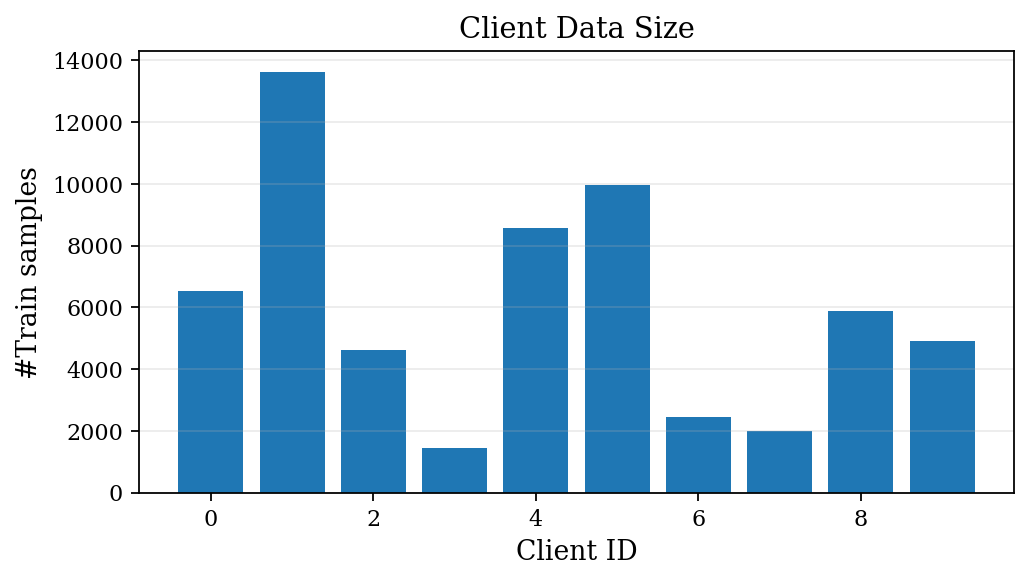

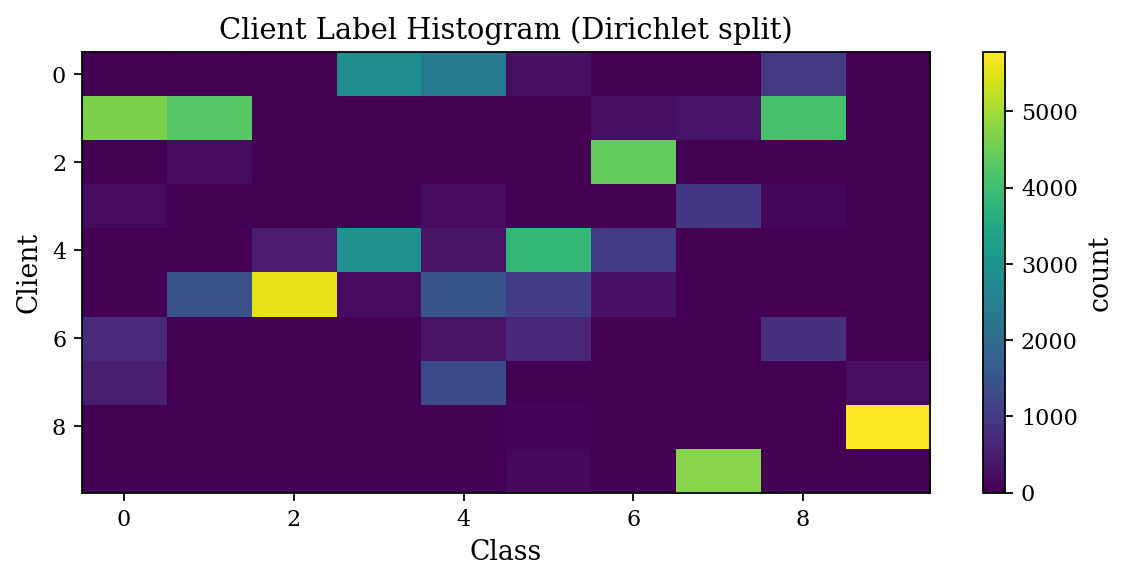


Run summary (acc in %; auto-normalized if stored as 0..1)
FedSCAM          | rounds=10 | final_acc= 65.41% | best_acc= 65.41% | final_loss=1.0819 | avg_time=144.63s
FedLESAM         | rounds=10 | final_acc= 65.76% | best_acc= 65.76% | final_loss=0.9388 | avg_time=163.85s
FedLW            | rounds=10 | final_acc= 46.53% | best_acc= 46.53% | final_loss=1.5918 | avg_time=131.31s
FedLWSAM         | rounds=10 | final_acc= 42.01% | best_acc= 42.01% | final_loss=1.9818 | avg_time=153.15s
FedNoLoWe        | rounds=10 | final_acc= 57.24% | best_acc= 57.24% | final_loss=1.0288 | avg_time=130.74s
FedWMSAM_prev    | rounds=10 | final_acc= 10.00% | best_acc= 17.76% | final_loss=3.4353 | avg_time=124.05s
FedWMSAM_exactGN | rounds=10 | final_acc= 52.68% | best_acc= 59.48% | final_loss=2.6829 | avg_time=15.78s


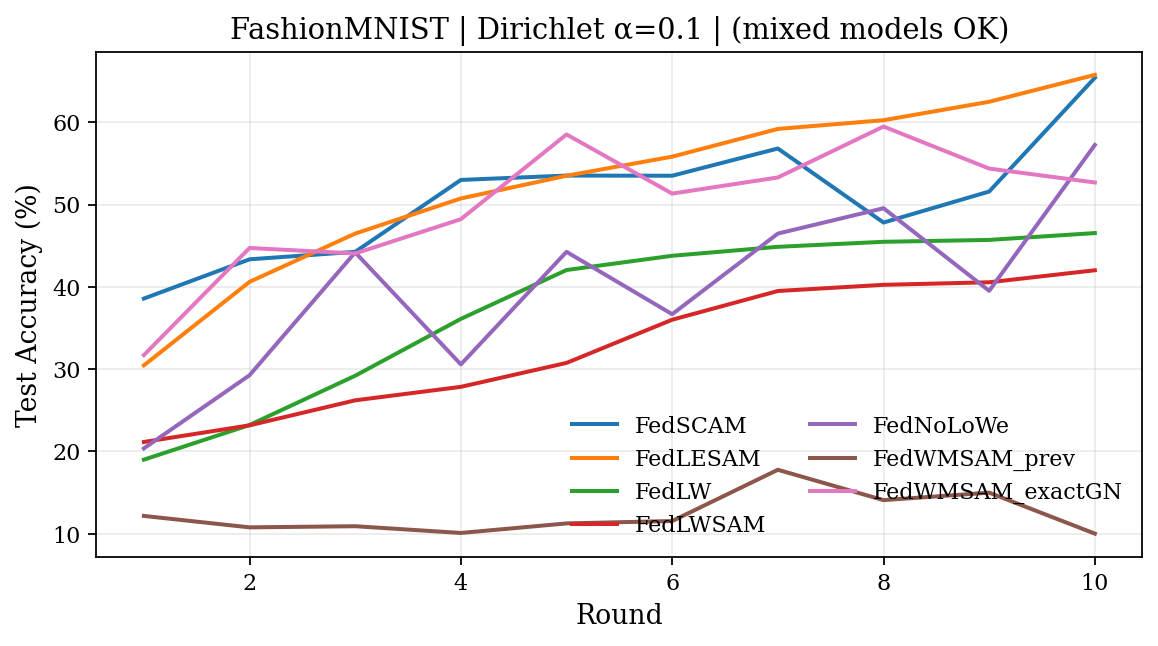

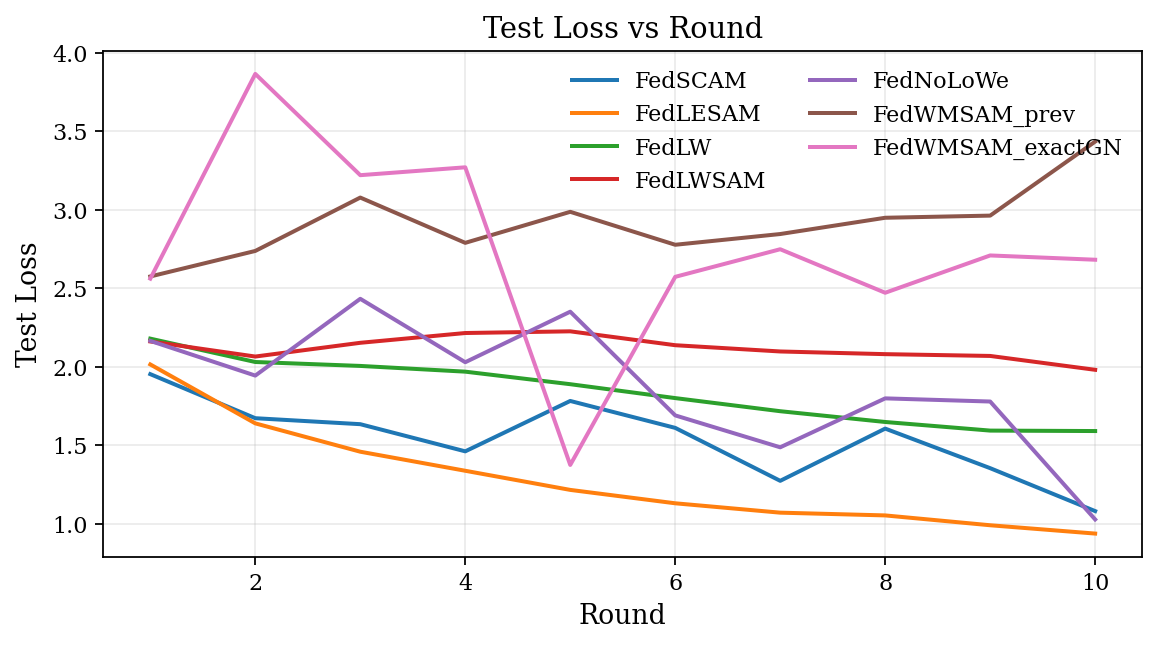

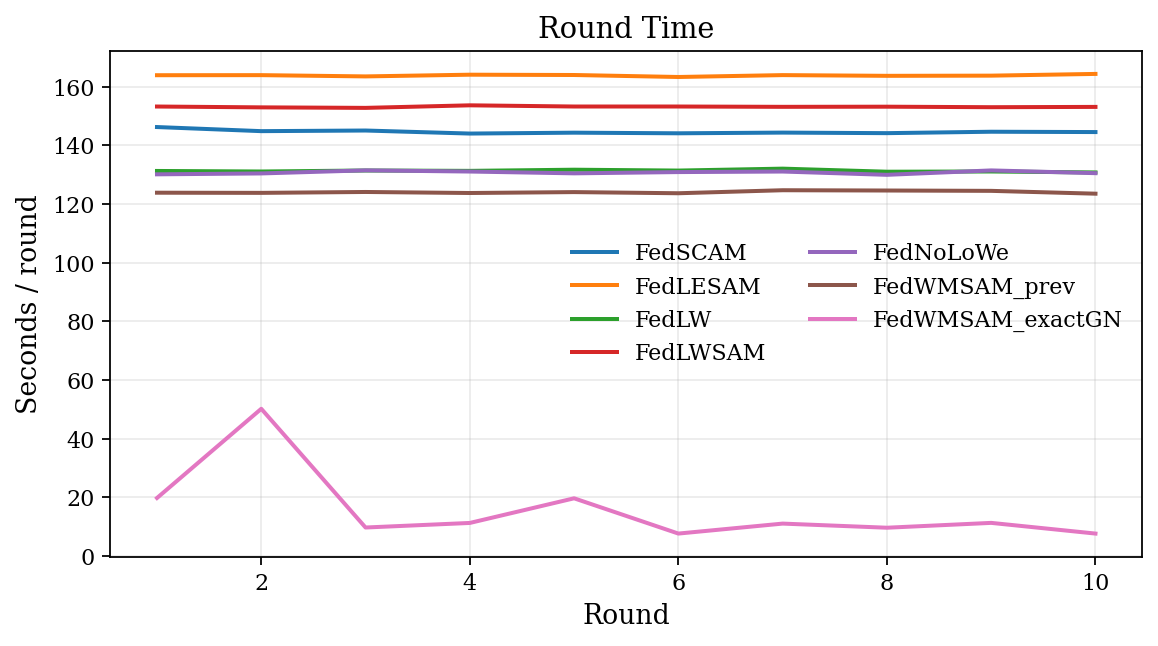

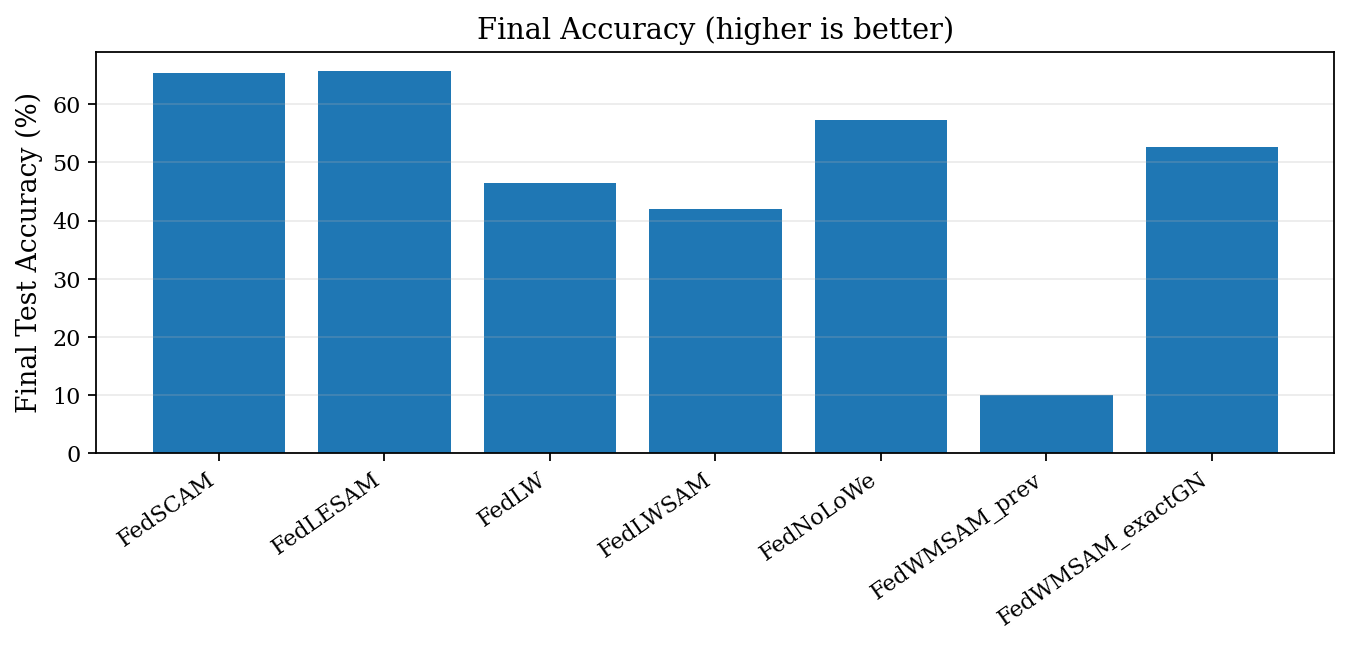

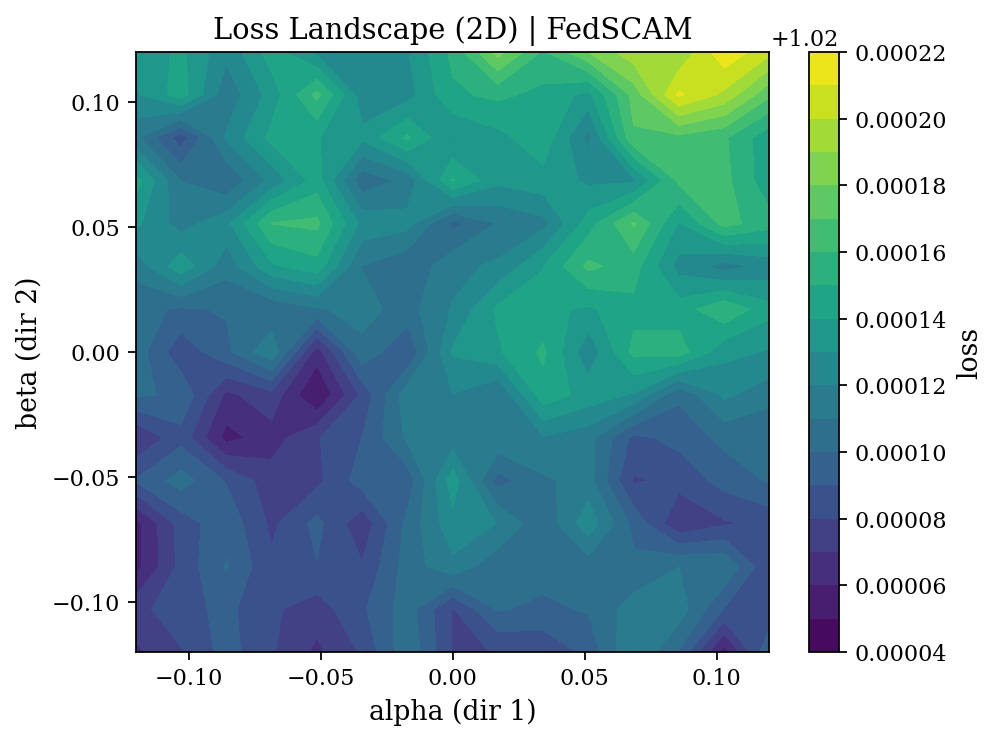

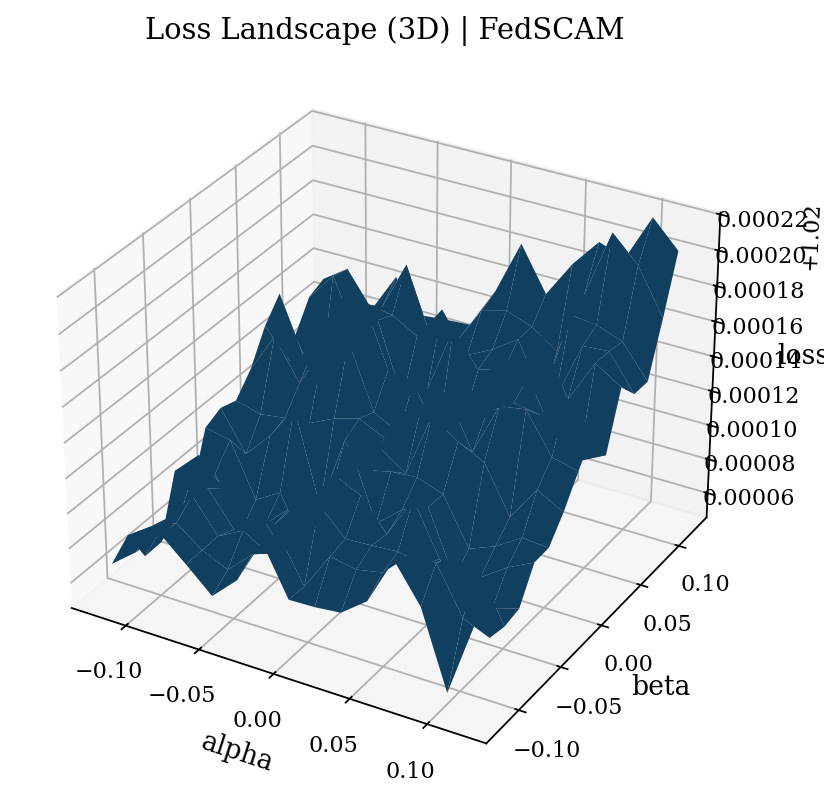

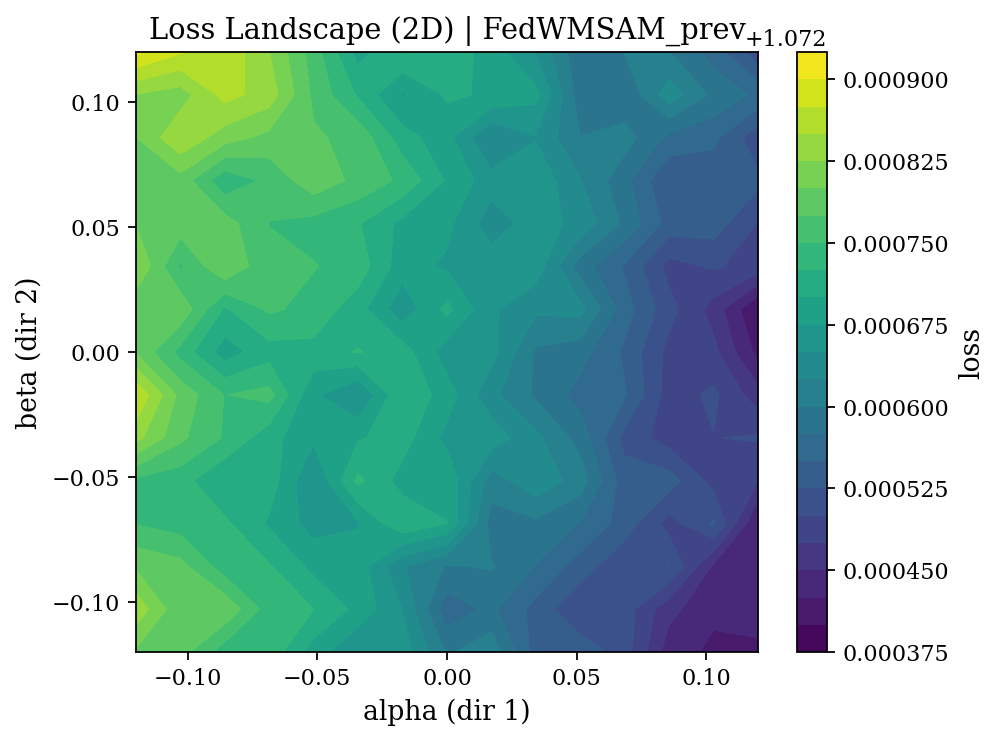

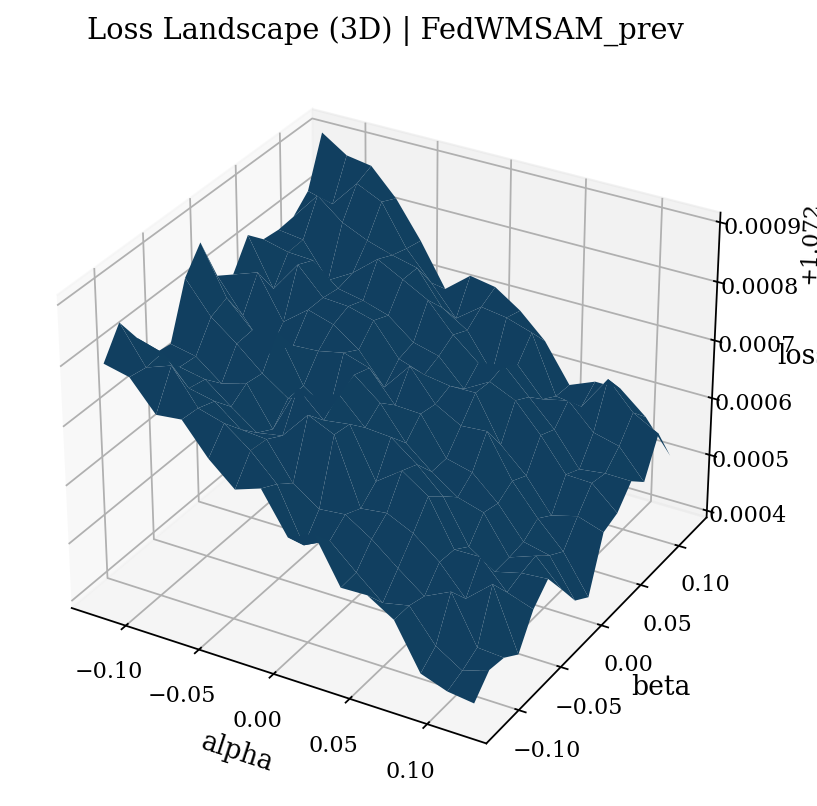

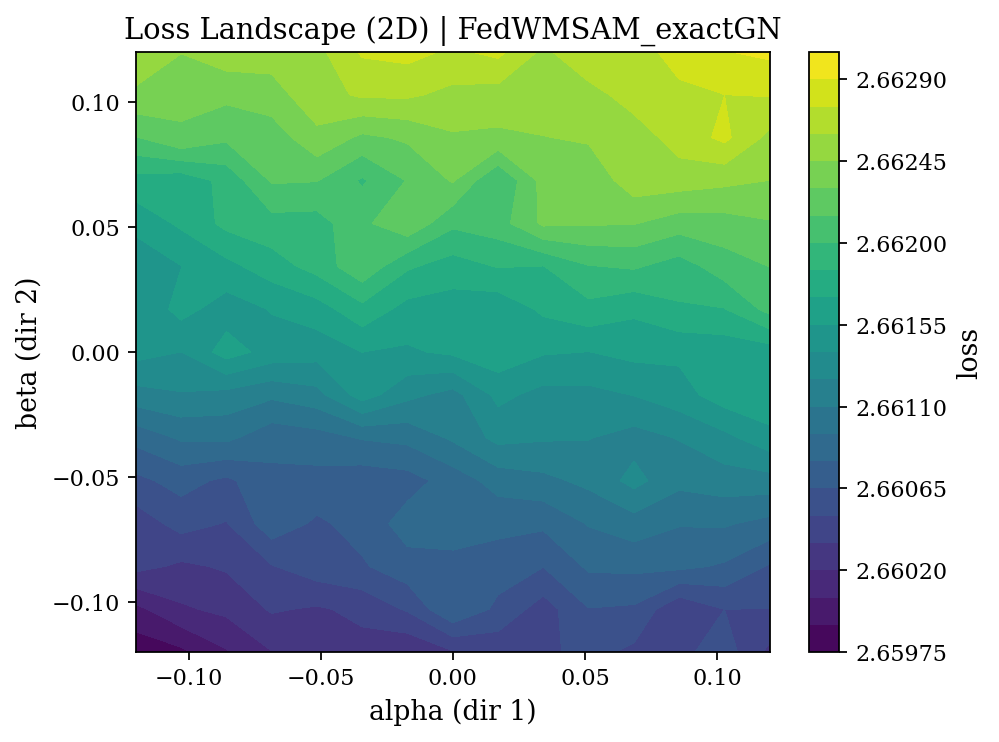

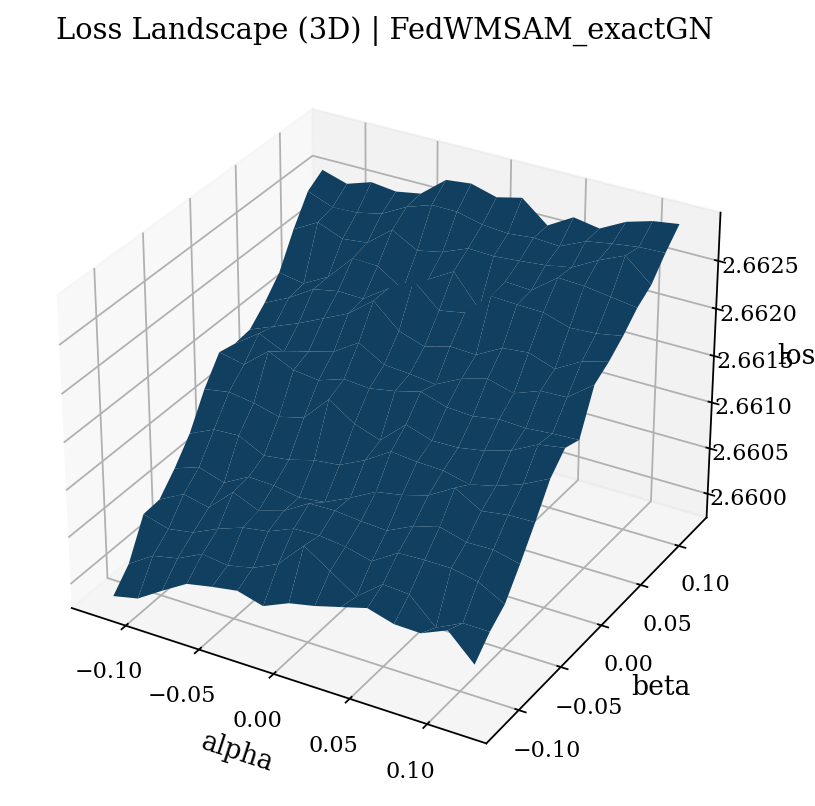

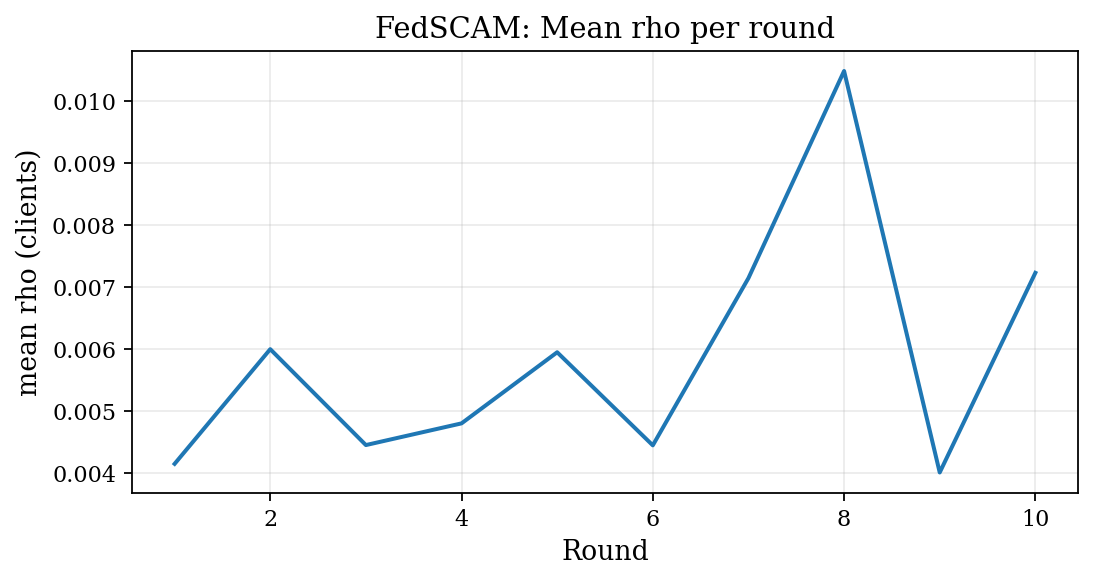

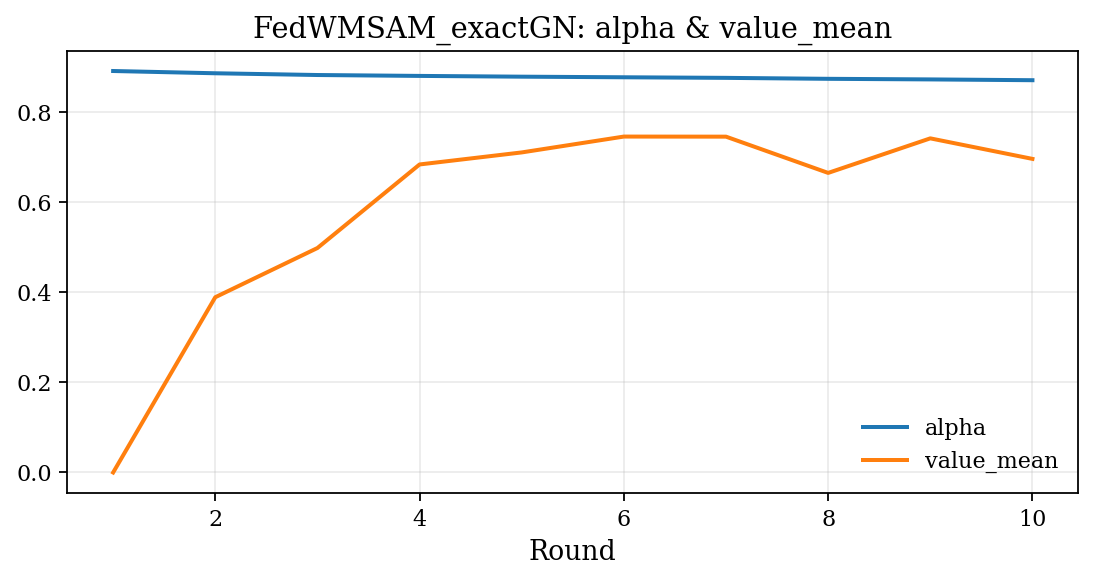

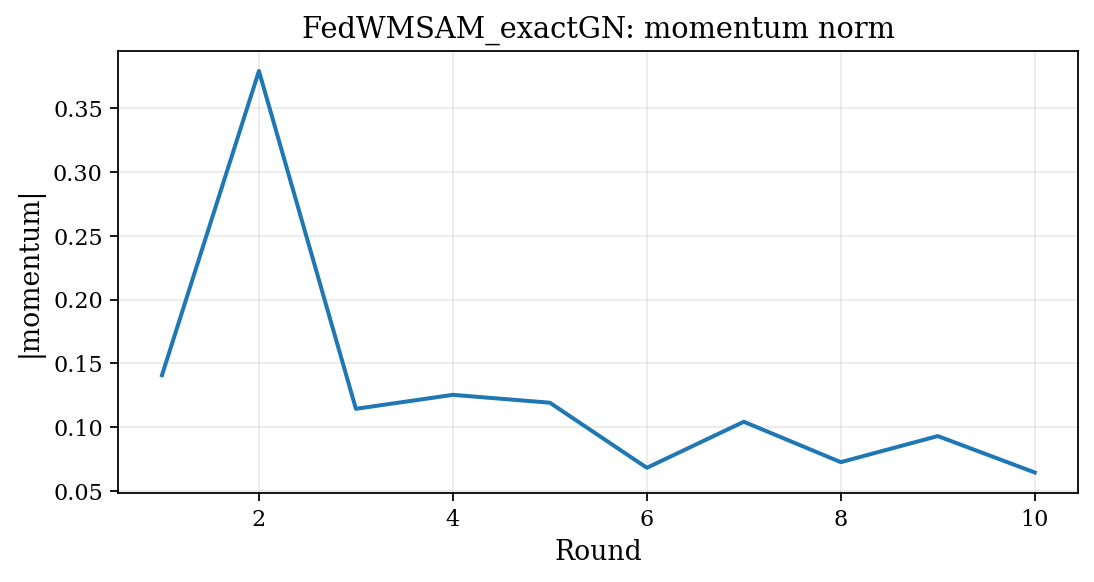

In [ ]:
# Cell 14 (REPLACE)  
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})


def _coerce_1d_list(x):
    if x is None:
        return []
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().flatten().tolist()
    elif isinstance(x, np.ndarray):
        x = x.flatten().tolist()
    elif isinstance(x, (list, tuple)):
        x = list(x)
    else:
        # scalar
        try:
            return [float(x)]
        except Exception:
            return []
    out = []
    for v in x:
        try:
            out.append(float(v))
        except Exception:
            pass
    return out

def _normalize_acc_to_percent(accs):
    accs = _coerce_1d_list(accs)
    if len(accs) == 0:
        return accs
    m = max(accs)
    # If acc looks like fraction (<=1.0), convert to percent
    if m <= 1.0 + 1e-6:
        return [a * 100.0 for a in accs]
    return accs

def _normalized_results(results_dict):
    """Return a *new* dict with accs in percent and lists coerced properly."""
    out = {}
    for k, v in results_dict.items():
        if not isinstance(v, dict):
            continue
        out[k] = dict(v)  # shallow copy
        out[k]["accs"]   = _normalize_acc_to_percent(v.get("accs", []))
        out[k]["losses"] = _coerce_1d_list(v.get("losses", []))
        out[k]["times"]  = _coerce_1d_list(v.get("times", []))
    return out

def _filtered_results(results_dict):
    # ignore only runs explicitly marked unofficial
    return {k: v for k, v in results_dict.items() if not str(k).endswith("_unofficial")}

def _select_for_plot(results_dict):
    """
    Keep a stable set/order so your figures don't get cluttered,
    and avoid accidentally plotting the broken FedWMSAM from Cell 13.1 if you don't want it.
    """
    preferred = [
        "FedSCAM",
        "FedLESAM",
        "FedLW",
        "FedLWSAM",
        "FedNoLoWe",
        "FedWMSAM_prev",     # whatever got stored here
        "FedWMSAM",          # may be overwritten by 13.1
        "FedWMSAM_exactGN",  # the one you trust now
    ]
    picked = {}
    for name in preferred:
        if name in results_dict:
            picked[name] = results_dict[name]

    # add anything else that exists (optional)
    for k, v in results_dict.items():
        if k not in picked:
            picked[k] = v

    # OPTIONAL: auto-drop a clearly broken FedWMSAM when exactGN exists
    # (keeps plots readable and matches your "ignore 13.1" intent)
    if "FedWMSAM_exactGN" in picked and "FedWMSAM" in picked:
        a = picked["FedWMSAM"].get("accs", [])
        a = _normalize_acc_to_percent(a)
        if len(a) and a[-1] <= 20.0:  # very likely the broken/impl-mismatch run
            picked.pop("FedWMSAM", None)

    return picked

# -----------------------------
# Summary + curves
# -----------------------------
def print_run_summary(results_dict):
    print("\n" + "="*80)
    print("Run summary (acc in %; auto-normalized if stored as 0..1)")
    print("="*80)

    for name, res in results_dict.items():
        a = res.get("accs", [])
        l = res.get("losses", [])
        t = res.get("times", [])
        if len(a) == 0:
            continue
        final_acc = a[-1]
        best_acc  = max(a)
        final_loss = l[-1] if len(l) else float("nan")
        avg_time = float(np.mean(t)) if len(t) else float("nan")
        print(f"{name:16s} | rounds={len(a):2d} | final_acc={final_acc:6.2f}% | best_acc={best_acc:6.2f}% "
              f"| final_loss={final_loss:.4f} | avg_time={avg_time:.2f}s")

def plot_curves(results_dict):
    title = f"FashionMNIST | Dirichlet α={CONFIG.get('dirichlet_alpha', 'N/A')} | (mixed models OK)"

    # Accuracy
    plt.figure(figsize=(7.4, 4.2))
    for name, res in results_dict.items():
        accs = res.get("accs", [])
        if len(accs) == 0:
            continue
        xs = np.arange(1, len(accs) + 1)
        plt.plot(xs, accs, label=name, linewidth=1.8)
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy (%)")
    plt.title(title)
    plt.grid(alpha=0.25)
    plt.legend(ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(7.4, 4.2))
    for name, res in results_dict.items():
        losses = res.get("losses", [])
        if len(losses) == 0:
            continue
        xs = np.arange(1, len(losses) + 1)
        plt.plot(xs, losses, label=name, linewidth=1.8)
    plt.xlabel("Round")
    plt.ylabel("Test Loss")
    plt.title("Test Loss vs Round")
    plt.grid(alpha=0.25)
    plt.legend(ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()

    # Time
    plt.figure(figsize=(7.4, 4.2))
    for name, res in results_dict.items():
        tt = res.get("times", [])
        if len(tt) == 0:
            continue
        xs = np.arange(1, len(tt) + 1)
        plt.plot(xs, tt, label=name, linewidth=1.8)
    plt.xlabel("Round")
    plt.ylabel("Seconds / round")
    plt.title("Round Time")
    plt.grid(alpha=0.25)
    plt.legend(ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()

    # Final accuracy bar
    names, finals = [], []
    for name, res in results_dict.items():
        accs = res.get("accs", [])
        if len(accs) == 0:
            continue
        names.append(name)
        finals.append(accs[-1])

    plt.figure(figsize=(8.6, 4.2))
    plt.bar(np.arange(len(names)), finals)
    plt.xticks(np.arange(len(names)), names, rotation=35, ha="right")
    plt.ylabel("Final Test Accuracy (%)")
    plt.title("Final Accuracy (higher is better)")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

def plot_client_stats():
    plt.figure(figsize=(6.6, 3.8))
    plt.bar(np.arange(CONFIG["num_clients"]), client_sizes)
    plt.xlabel("Client ID")
    plt.ylabel("#Train samples")
    plt.title("Client Data Size")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

    labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))], dtype=np.int64)
    mat = np.zeros((CONFIG["num_clients"], 10), dtype=np.int64)
    for cid, idxs in enumerate(client_indices):
        for ix in idxs:
            mat[cid, labels[ix]] += 1

    plt.figure(figsize=(7.4, 3.8))
    plt.imshow(mat, aspect="auto")
    plt.colorbar(label="count")
    plt.xlabel("Class")
    plt.ylabel("Client")
    plt.title("Client Label Histogram (Dirichlet split)")
    plt.tight_layout()
    plt.show()


def _prep_x_for_model(model, x):
    # If model expects 3ch and x is 1ch, repeat channels (needed for ResNet18 GN on FashionMNIST)
    try:
        # common case: model.conv1 exists (ResNet)
        if hasattr(model, "conv1") and hasattr(model.conv1, "weight"):
            in_ch = int(model.conv1.weight.shape[1])
            if x.dim() == 4 and x.size(1) == 1 and in_ch == 3:
                return x.repeat(1, 3, 1, 1)
    except Exception:
        pass
    return x

def loss_landscape_2d3d(final_state, title, model_fn=None, grid=15, span=0.12, n_batches=3):
    # Require vector utils
    if ("state_to_vec" not in globals()) or ("vec_to_state" not in globals()):
        print(f"[landscape] Skipping {title}: state_to_vec/vec_to_state not found in globals.")
        return

    if model_fn is None:
        model_fn = create_model

    model = model_fn().to(device)
    try:
        model.load_state_dict(final_state)
    except Exception as e:
        print(f"[landscape] Skipping {title}: state_dict incompatible with model_fn. ({e})")
        return

    base = state_to_vec(model.state_dict())
    d1 = np.random.randn(base.size).astype(np.float32)
    d2 = np.random.randn(base.size).astype(np.float32)
    d1 = d1 / (np.linalg.norm(d1) + 1e-12)
    d2 = d2 / (np.linalg.norm(d2) + 1e-12)

    alphas = np.linspace(-span, span, grid).astype(np.float32)
    betas  = np.linspace(-span, span, grid).astype(np.float32)
    Z = np.zeros((grid, grid), dtype=np.float32)

    batches = []
    for i, (x, y) in enumerate(test_loader):
        batches.append((x.to(device), y.to(device)))
        if i + 1 >= n_batches:
            break

    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            w = base + a * d1 + b * d2
            state = vec_to_state(w, final_state)
            model.load_state_dict(state)

            with torch.no_grad():
                ls, n = 0.0, 0
                for x, y in batches:
                    x2 = _prep_x_for_model(model, x)
                    out = model(x2)
                    ls += F.cross_entropy(out, y, reduction="sum").item()
                    n += y.size(0)
            Z[i, j] = ls / max(1, n)

    A, B = np.meshgrid(alphas, betas, indexing="ij")

    plt.figure(figsize=(6.4, 4.8))
    cs = plt.contourf(A, B, Z, levels=20)
    plt.colorbar(cs, label="loss")
    plt.xlabel("alpha (dir 1)")
    plt.ylabel("beta (dir 2)")
    plt.title(f"Loss Landscape (2D) | {title}")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(7.2, 5.2))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(A, B, Z, linewidth=0, antialiased=True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("beta")
    ax.set_zlabel("loss")
    ax.set_title(f"Loss Landscape (3D) | {title}")
    plt.tight_layout()
    plt.show()

    del model
    if "clear_mem" in globals():
        clear_mem()


plot_client_stats()

# Normalize + filter + pick what to plot
_norm = _normalized_results(results)
_norm = _filtered_results(_norm)
plot_results = _select_for_plot(_norm)

print_run_summary(plot_results)
plot_curves(plot_results)

# Landscapes (only if compatible)
if "FedSCAM" in plot_results:
    loss_landscape_2d3d(
        plot_results["FedSCAM"].get("final_state", None),
        "FedSCAM",
        model_fn=plot_results["FedSCAM"].get("model_fn", None),
        grid=15, span=0.12, n_batches=3
    )

if "FedWMSAM_prev" in plot_results:
    loss_landscape_2d3d(
        plot_results["FedWMSAM_prev"].get("final_state", None),
        "FedWMSAM_prev",
        model_fn=plot_results["FedWMSAM_prev"].get("model_fn", None),
        grid=15, span=0.12, n_batches=3
    )

if "FedWMSAM_exactGN" in plot_results:
    loss_landscape_2d3d(
        plot_results["FedWMSAM_exactGN"].get("final_state", None),
        "FedWMSAM_exactGN",
        model_fn=plot_results["FedWMSAM_exactGN"].get("model_fn", None),
        grid=15, span=0.12, n_batches=3
    )

#FedSCAM internals (rho)
if "FedSCAM" in plot_results and "debug_logs" in plot_results["FedSCAM"]:
    dbg = plot_results["FedSCAM"]["debug_logs"]
    rho_means = [np.mean(d["rho_used"]) for d in dbg]
    plt.figure(figsize=(7.0, 3.8))
    plt.plot(np.arange(1, len(rho_means)+1), rho_means, linewidth=1.8)
    plt.xlabel("Round")
    plt.ylabel("mean rho (clients)")
    plt.title("FedSCAM: Mean rho per round")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

#FedWMSAM_exactGN internals (alpha, value_mean, mom_norm)
if "FedWMSAM_exactGN" in plot_results and "debug_logs" in plot_results["FedWMSAM_exactGN"]:
    dbg = plot_results["FedWMSAM_exactGN"]["debug_logs"]
    alphas = [d.get("alpha", np.nan) for d in dbg]
    vals   = [d.get("value_mean", np.nan) for d in dbg]
    moms   = [d.get("mom_norm", np.nan) for d in dbg]

    xs = np.arange(1, len(alphas)+1)

    plt.figure(figsize=(7.0, 3.8))
    plt.plot(xs, alphas, linewidth=1.8, label="alpha")
    plt.plot(xs, vals,   linewidth=1.8, label="value_mean")
    plt.xlabel("Round")
    plt.title("FedWMSAM_exactGN: alpha & value_mean")
    plt.grid(alpha=0.25)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7.0, 3.8))
    plt.plot(xs, moms, linewidth=1.8)
    plt.xlabel("Round")
    plt.ylabel("|momentum|")
    plt.title("FedWMSAM_exactGN: momentum norm")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


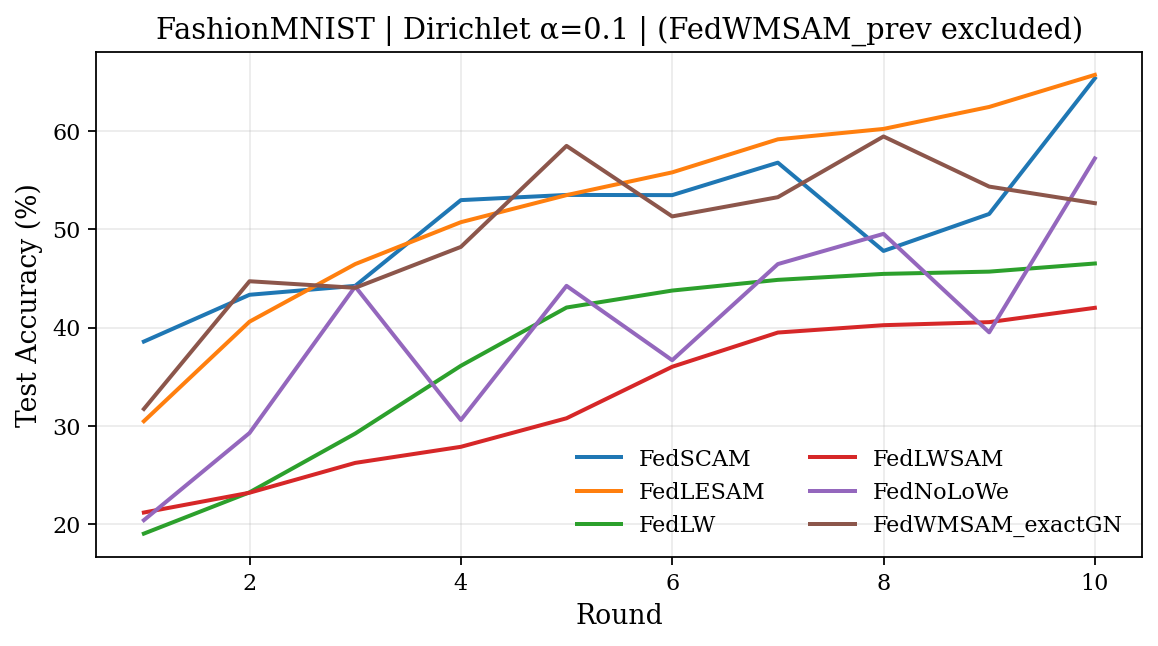

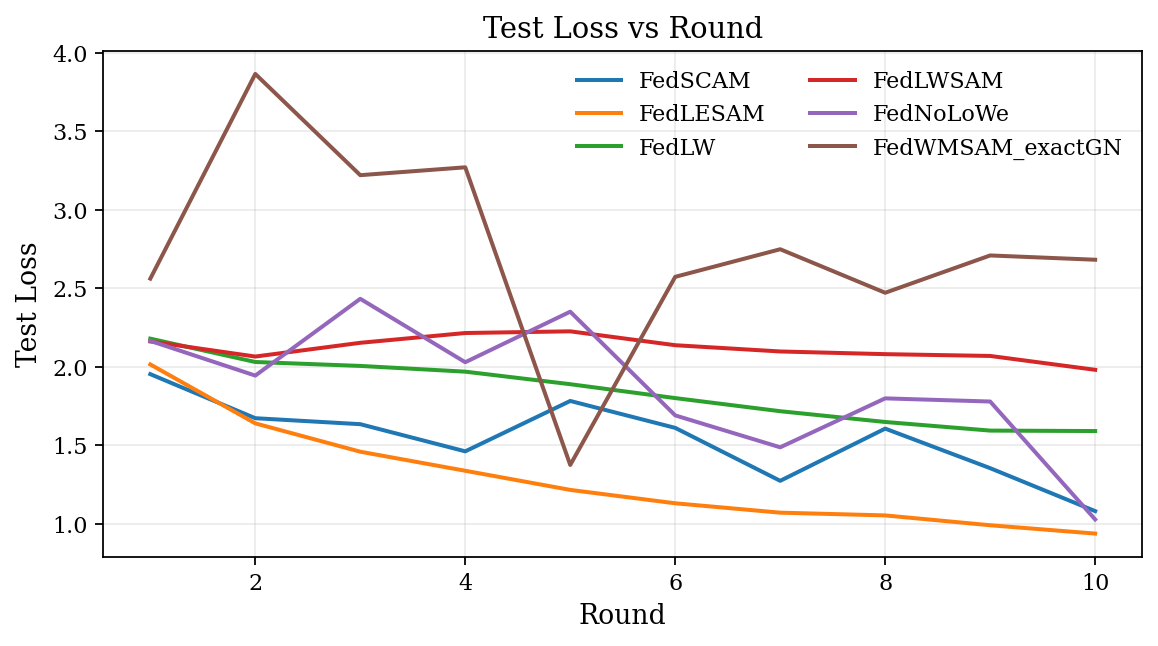

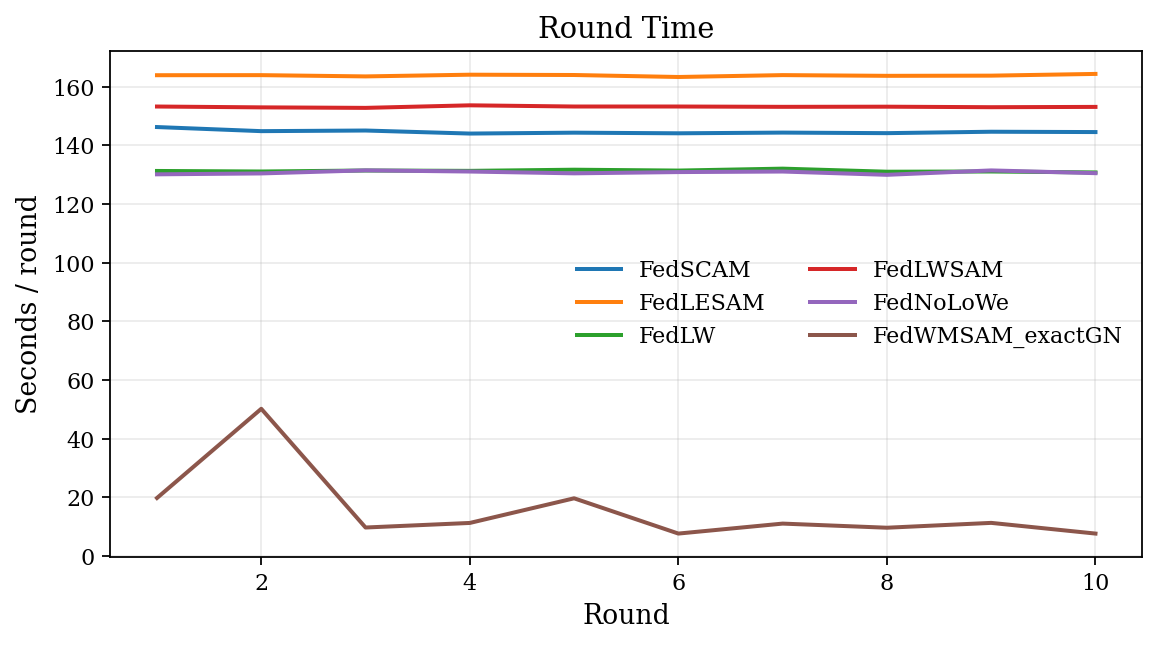

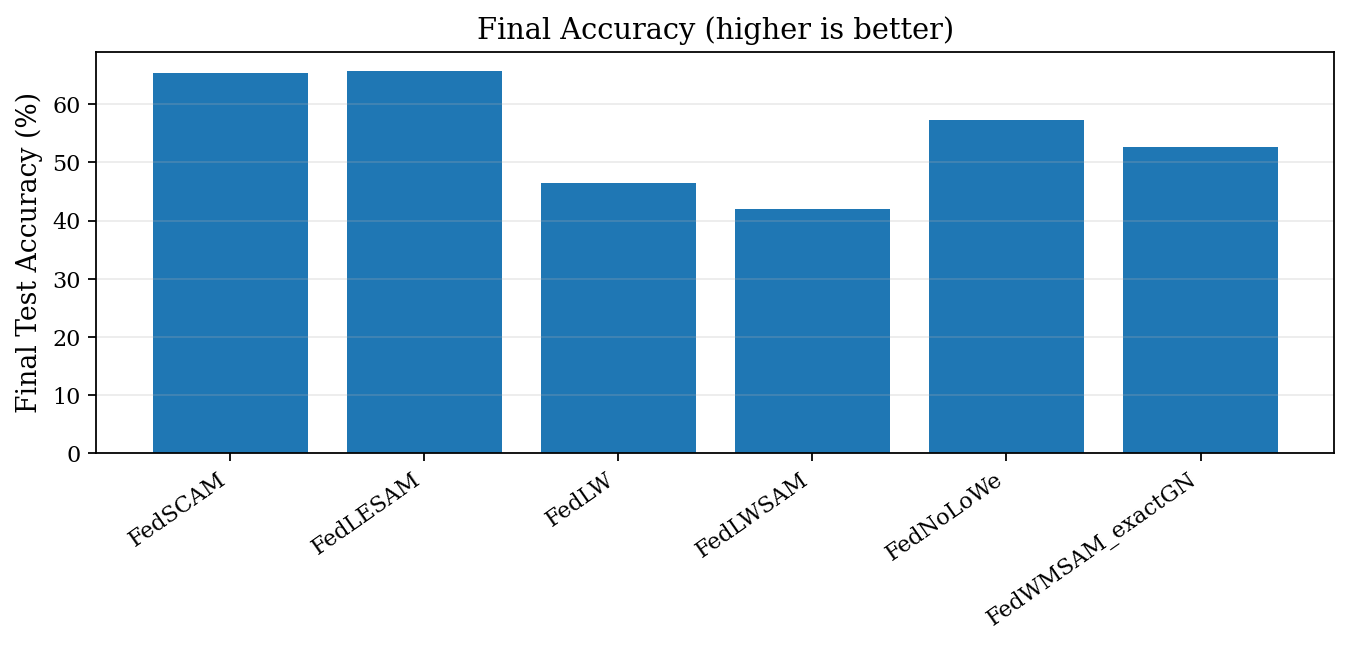

In [ ]:
# Cell 15


import numpy as np
import matplotlib.pyplot as plt
import torch

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})

def _coerce_1d_list(x):
    if x is None:
        return []
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().flatten().tolist()
    if isinstance(x, np.ndarray):
        return x.flatten().tolist()
    if isinstance(x, (list, tuple)):
        out = []
        for v in x:
            try:
                out.append(float(v))
            except Exception:
                pass
        return out
    try:
        return [float(x)]
    except Exception:
        return []

def _normalize_acc_to_percent(accs):
    accs = _coerce_1d_list(accs)
    if len(accs) == 0:
        return accs
    if max(accs) <= 1.0 + 1e-6:
        return [a * 100.0 for a in accs]
    return accs

def _normalize_results_dict(results_dict):
    out = {}
    for k, v in results_dict.items():
        if not isinstance(v, dict):
            continue
        out[k] = dict(v)
        out[k]["accs"]   = _normalize_acc_to_percent(v.get("accs", []))
        out[k]["losses"] = _coerce_1d_list(v.get("losses", []))
        out[k]["times"]  = _coerce_1d_list(v.get("times", []))
    return out

def _filter_exclude(results_dict, exclude_keys=None):
    if exclude_keys is None:
        exclude_keys = set()
    out = {}
    for k, v in results_dict.items():
        if k in exclude_keys:
            continue
        if str(k).endswith("_unofficial" or "FEDWMSAM" or "FedWMSAM") :
            continue
        out[k] = v
    return out


exclude = {"FedWMSAM_prev", "FedWMSAM", "FEDWMSAM"} 
plot_dict = _normalize_results_dict(results)
plot_dict = _filter_exclude(plot_dict, exclude_keys=exclude)


preferred_order = [
    "FedSCAM", "FedLESAM", "FedLW", "FedLWSAM", "FedNoLoWe",
    "FedWMSAM_exactGN", "FedWMSAM"
]
ordered = {}
for k in preferred_order:
    if k in plot_dict:
        ordered[k] = plot_dict[k]
for k, v in plot_dict.items():
    if k not in ordered:
        ordered[k] = v
plot_dict = ordered


title = f"FashionMNIST | Dirichlet α={CONFIG.get('dirichlet_alpha','N/A')} | (FedWMSAM_prev excluded)"

# Accuracy curves
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_dict.items():
    accs = res.get("accs", [])
    if len(accs) == 0:
        continue
    xs = np.arange(1, len(accs) + 1)
    plt.plot(xs, accs, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.title(title)
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Loss curves
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_dict.items():
    losses = res.get("losses", [])
    if len(losses) == 0:
        continue
    xs = np.arange(1, len(losses) + 1)
    plt.plot(xs, losses, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Round")
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Time curves
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_dict.items():
    times = res.get("times", [])
    if len(times) == 0:
        continue
    xs = np.arange(1, len(times) + 1)
    plt.plot(xs, times, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Seconds / round")
plt.title("Round Time")
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Final accuracy bar 
names, finals = [], []
for name, res in plot_dict.items():
    accs = res.get("accs", [])
    if len(accs) == 0:
        continue
    names.append(name)
    finals.append(accs[-1])

plt.figure(figsize=(8.6, 4.2))
plt.bar(np.arange(len(names)), finals)
plt.xticks(np.arange(len(names)), names, rotation=35, ha="right")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Final Accuracy (higher is better)")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 16 

import time, copy, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset


if "results" not in globals() or results is None:
    results = {}


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        if rho < 0.0:
            raise ValueError(f"Invalid rho: {rho}")
        self.rho = rho
        self.adaptive = adaptive
        self.base_optimizer = base_optimizer
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)

    @torch.no_grad()
    def _grad_norm(self):
        device = self.param_groups[0]["params"][0].device
        norms = []
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                if self.adaptive:
                    # adaptive SAM
                    norms.append(((torch.abs(p) * p.grad).norm(p=2)).to(device))
                else:
                    norms.append((p.grad.norm(p=2)).to(device))
        if len(norms) == 0:
            return torch.tensor(0.0, device=device)
        return torch.norm(torch.stack(norms), p=2)

    @torch.no_grad()
    def first_step(self, zero_grad=True):
        grad_norm = self._grad_norm()
        scale = self.rho / (grad_norm + 1e-12)

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                if self.adaptive:
                    e_w = torch.pow(p, 2) * p.grad * scale.to(p)
                else:
                    e_w = p.grad * scale.to(p)

                p.add_(e_w)  # ascent step
                self.state[p]["e_w"] = e_w

        if zero_grad:
            self.zero_grad(set_to_none=True)

    @torch.no_grad()
    def second_step(self, zero_grad=True):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = self.state[p].get("e_w", None)
                if e_w is None:
                    continue
                p.sub_(e_w)  # back to original point

        self.base_optimizer.step()

        if zero_grad:
            self.zero_grad(set_to_none=True)

    def step(self, closure=None):
        # Not used directly; we do explicit 2-step in the client loop.
        raise NotImplementedError("Use first_step/second_step with two forward-backward passes.")

@torch.no_grad()
def _eval_model(model):
    model.eval()
    tot_loss, tot_correct, tot_n = 0.0, 0, 0
    for x, y in test_loader:
        x = x.to(device); y = y.to(device)
        out = model(x)
        tot_loss += F.cross_entropy(out, y, reduction="sum").item()
        tot_correct += (out.argmax(dim=1) == y).sum().item()
        tot_n += y.numel()
    return tot_loss / max(1, tot_n), 100.0 * tot_correct / max(1, tot_n)


def run_fedsam(rounds=10):
    rounds = int(rounds)
    num_clients = int(CONFIG["num_clients"])
    client_frac = float(CONFIG.get("client_frac", 1.0))
    clients_per_round = max(1, int(round(num_clients * client_frac)))

    lr = float(CONFIG["lr"])
    local_epochs = int(CONFIG["local_epochs"])
    batch_size = int(CONFIG["batch_size"])
    weight_decay = float(CONFIG.get("weight_decay", 0.0))
    momentum = float(CONFIG.get("momentum", 0.9))

    sam_rho = float(CONFIG.get("sam_rho", 0.05))
    sam_adaptive = bool(CONFIG.get("sam_adaptive", False))

    # Build client loaders once
    client_loaders = []
    client_sizes_local = []
    for cid in range(num_clients):
        idxs = client_indices[cid]
        client_sizes_local.append(len(idxs))
        subset = Subset(train_dataset, idxs)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
        client_loaders.append(loader)

    global_model = create_model().to(device)

    losses, accs, times = [], [], []
    final_state = None

    print("\n" + "="*80)
    print("FedSAM")
    print("="*80)
    print(f"rounds={rounds} clients={num_clients} clients/round={clients_per_round} "
          f"local_epochs={local_epochs} batch={batch_size} lr={lr} wd={weight_decay} mom={momentum} rho={sam_rho}")

    for r in range(1, rounds + 1):
        t0 = time.perf_counter()

        # client selection
        if clients_per_round >= num_clients:
            selected = list(range(num_clients))
        else:
            selected = np.random.choice(num_clients, size=clients_per_round, replace=False).tolist()

        local_states = []
        local_weights = []

        for cid in selected:
            if client_sizes_local[cid] <= 0:
                continue

            model = create_model().to(device)
            model.load_state_dict(global_model.state_dict())

            base_opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            sam_opt = SAM(model.parameters(), base_optimizer=base_opt, rho=sam_rho, adaptive=sam_adaptive)

            model.train()
            for _ in range(local_epochs):
                for x, y in client_loaders[cid]:
                    x = x.to(device); y = y.to(device)

                    # 1) gradients at w
                    out = model(x)
                    loss = F.cross_entropy(out, y, reduction="mean")
                    loss.backward()
                    sam_opt.first_step(zero_grad=True)

                    # 2) gradients at w + e(w)
                    out2 = model(x)
                    loss2 = F.cross_entropy(out2, y, reduction="mean")
                    loss2.backward()
                    sam_opt.second_step(zero_grad=True)

            local_states.append({k: v.detach().cpu() for k, v in model.state_dict().items()})
            local_weights.append(client_sizes_local[cid])

            del model
            if "clear_mem" in globals():
                clear_mem()

  
        if len(local_states) == 0:
            te_loss, te_acc = _eval_model(global_model)
            losses.append(float(te_loss)); accs.append(float(te_acc))
            times.append(float(time.perf_counter() - t0))
            print(f"[FedSAM   ] Round {r:02d}/{rounds} | loss={te_loss:.4f} | acc={te_acc:6.2f}% | time={times[-1]:.2f}s (no clients)")
            continue

        wsum = float(sum(local_weights))
        new_state = {}
        for k in global_model.state_dict().keys():
            acc = None
            for st, w in zip(local_states, local_weights):
                t = st[k].float() * (float(w) / (wsum + 1e-12))
                acc = t if acc is None else (acc + t)
            new_state[k] = acc
        global_model.load_state_dict(new_state)

        te_loss, te_acc = _eval_model(global_model)
        dt = time.perf_counter() - t0

        losses.append(float(te_loss))
        accs.append(float(te_acc))
        times.append(float(dt))
        final_state = {k: v.detach().cpu() for k, v in global_model.state_dict().items()}

        print(f"[FedSAM   ] Round {r:02d}/{rounds} | loss={te_loss:.4f} | acc={te_acc:6.2f}% | time={dt:.2f}s", flush=True)

    return {
        "losses": losses,
        "accs": accs,
        "times": times,
        "final_state": final_state,
        "model_fn": create_model,  
    }

results["FedSAM"] = run_fedsam(rounds=10)
print("\nDone. Added/updated key: FedSAM")
print("Now results keys:", list(results.keys()))



FedSAM
rounds=10 clients=10 clients/round=10 local_epochs=5 batch=256 lr=0.01 wd=0.0 mom=0.9 rho=0.05
[FedSAM   ] Round 01/10 | loss=2.2142 | acc= 22.22% | time=129.67s
[FedSAM   ] Round 02/10 | loss=1.6434 | acc= 47.62% | time=128.53s
[FedSAM   ] Round 03/10 | loss=2.4603 | acc= 25.83% | time=128.69s
[FedSAM   ] Round 04/10 | loss=1.4612 | acc= 49.74% | time=128.98s
[FedSAM   ] Round 05/10 | loss=2.2988 | acc= 32.39% | time=128.97s
[FedSAM   ] Round 06/10 | loss=1.1222 | acc= 56.89% | time=129.60s
[FedSAM   ] Round 07/10 | loss=2.4198 | acc= 43.65% | time=128.06s
[FedSAM   ] Round 08/10 | loss=1.1470 | acc= 55.91% | time=129.86s
[FedSAM   ] Round 09/10 | loss=1.6533 | acc= 37.83% | time=128.06s
[FedSAM   ] Round 10/10 | loss=1.1077 | acc= 62.51% | time=128.76s

Done. Added/updated key: FedSAM
Now results keys: ['FedSCAM', 'FedLESAM', 'FedWMSAM', 'FedLW', 'FedLWSAM', 'FedNoLoWe', 'FedWMSAM_prev', 'FedWMSAM_exactGN', 'FedSAM']



Run summary (ONLY requested methods; acc auto-normalized to % if stored as 0..1)
FedSCAM    | rounds=10 | final_acc= 65.41% | best_acc= 65.41% | final_loss=1.0819 | avg_time=144.63s
FedLESAM   | rounds=10 | final_acc= 65.76% | best_acc= 65.76% | final_loss=0.9388 | avg_time=163.85s
FedSAM     | rounds=10 | final_acc= 62.51% | best_acc= 62.51% | final_loss=1.1077 | avg_time=128.92s
FedLW      | rounds=10 | final_acc= 46.53% | best_acc= 46.53% | final_loss=1.5918 | avg_time=131.31s
FedLWSAM   | rounds=10 | final_acc= 42.01% | best_acc= 42.01% | final_loss=1.9818 | avg_time=153.15s
FedWMSAM   | rounds=10 | final_acc= 52.68% | best_acc= 59.48% | final_loss=2.6829 | avg_time=15.78s


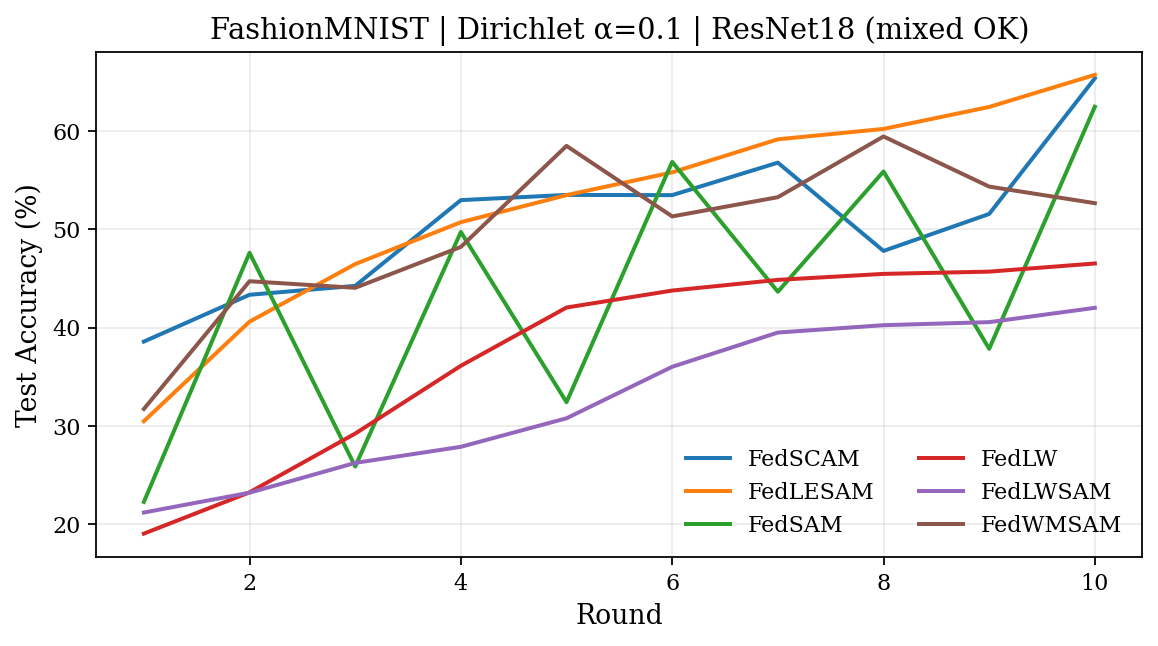

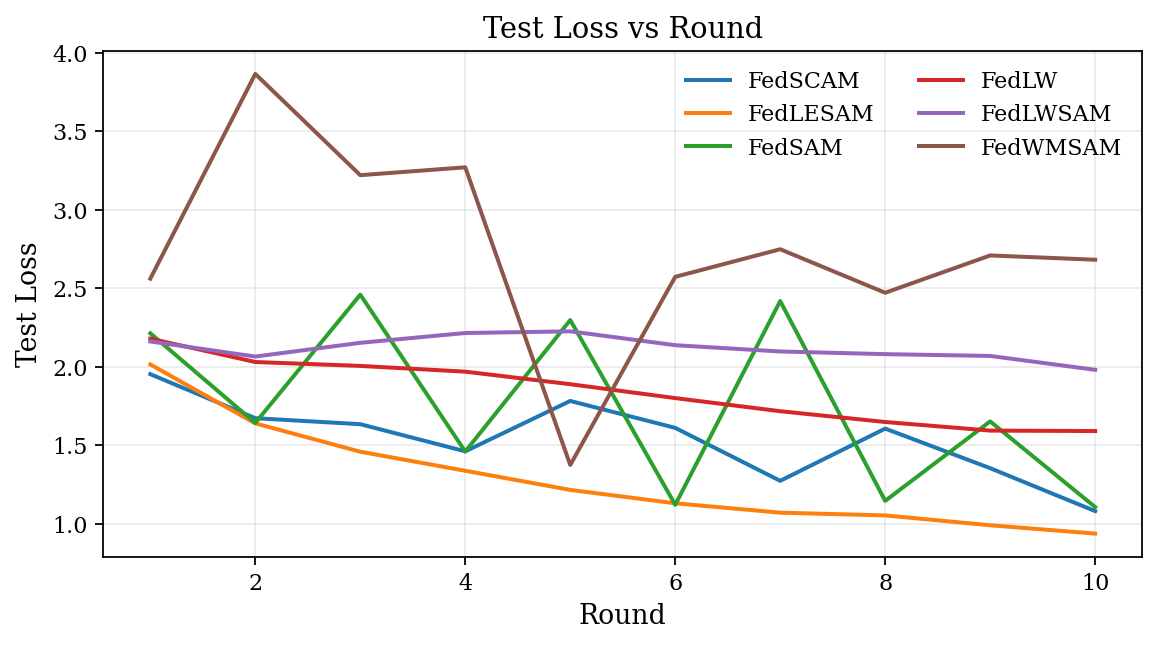

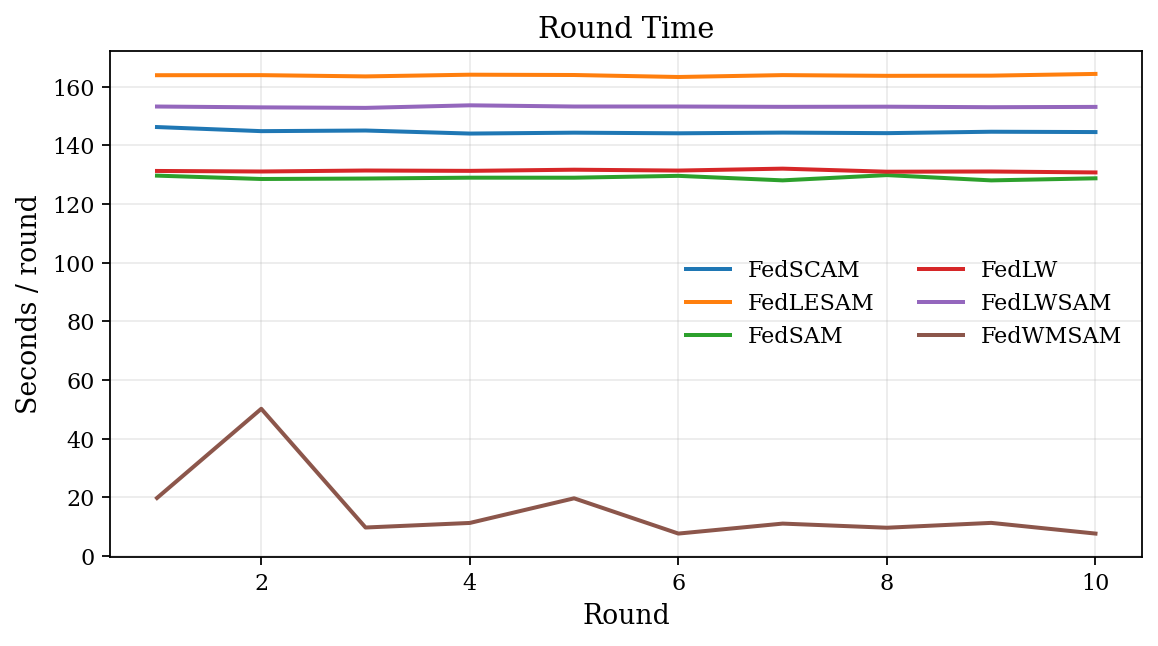

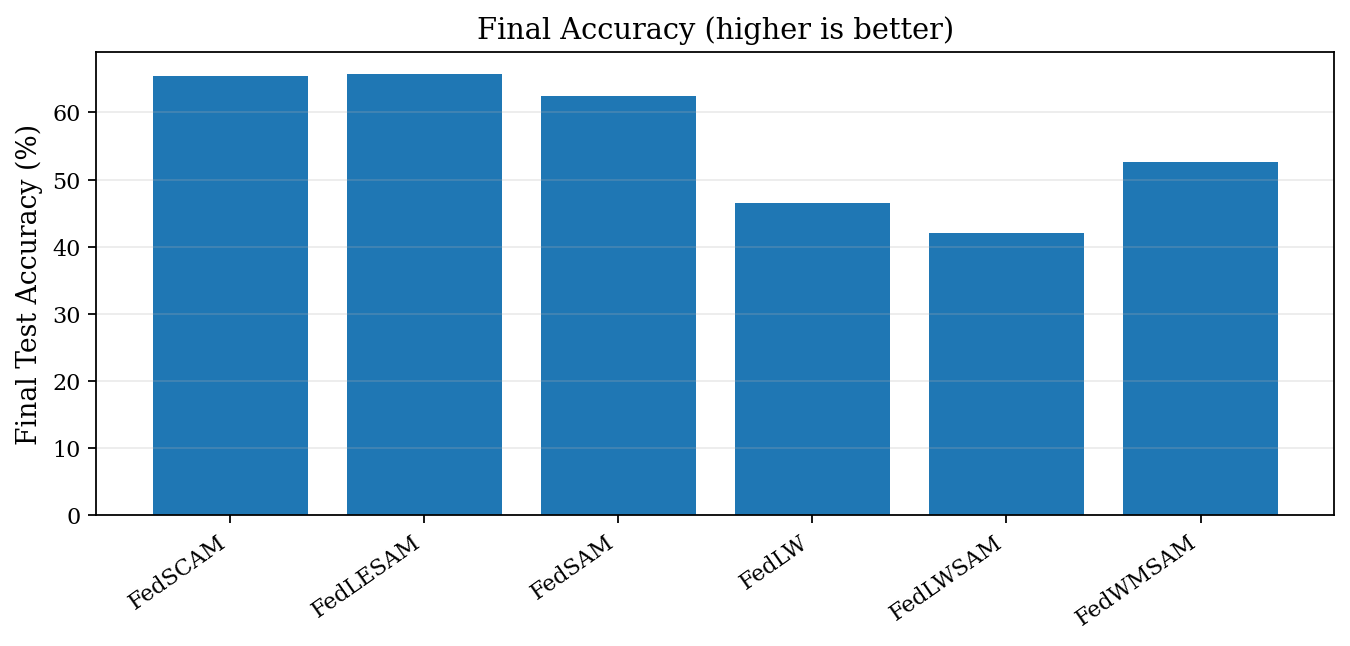

In [ ]:
# Cell 17 


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})


def _coerce_1d_list(x):
    if x is None:
        return []
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().flatten().tolist()
    elif isinstance(x, np.ndarray):
        x = x.flatten().tolist()
    elif isinstance(x, (list, tuple)):
        x = list(x)
    else:
        try:
            return [float(x)]
        except Exception:
            return []
    out = []
    for v in x:
        try:
            out.append(float(v))
        except Exception:
            pass
    return out

def _normalize_acc_to_percent(accs):
    accs = _coerce_1d_list(accs)
    if len(accs) == 0:
        return accs
    if max(accs) <= 1.0 + 1e-6:
        return [a * 100.0 for a in accs]
    return accs

def _norm_res(res):
    r = dict(res)
    r["accs"]   = _normalize_acc_to_percent(res.get("accs", []))
    r["losses"] = _coerce_1d_list(res.get("losses", []))
    r["times"]  = _coerce_1d_list(res.get("times", []))
    return r


wanted = [
    ("FedSCAM", "FedSCAM"),
    ("FedLESAM", "FedLESAM"),
    ("FedSAM", "FedSAM"),
    ("FedLW", "FedLW"),
    ("FedLWSAM", "FedLWSAM"),
    ("FedWMSAM", "FedWMSAM_exactGN"),  # only the exact/final version
]

plot_results = {}
missing = []
for disp, key in wanted:
    if key in results and isinstance(results[key], dict):
        plot_results[disp] = _norm_res(results[key])
    else:
        missing.append(key)

if len(missing):
    print("[Cell 17] Missing (not plotted):", missing)

print("\n" + "="*80)
print("Run summary (ONLY requested methods; acc auto-normalized to % if stored as 0..1)")
print("="*80)
for name, res in plot_results.items():
    a = res.get("accs", [])
    l = res.get("losses", [])
    t = res.get("times", [])
    if len(a) == 0:
        continue
    print(f"{name:10s} | rounds={len(a):2d} | final_acc={a[-1]:6.2f}% | best_acc={max(a):6.2f}% "
          f"| final_loss={(l[-1] if len(l) else float('nan')):.4f} | avg_time={(np.mean(t) if len(t) else float('nan')):.2f}s")


title = f"FashionMNIST | Dirichlet α={CONFIG.get('dirichlet_alpha','N/A')} | ResNet18 (mixed OK)"

# Accuracy
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_results.items():
    accs = res.get("accs", [])
    if len(accs) == 0:
        continue
    xs = np.arange(1, len(accs) + 1)
    plt.plot(xs, accs, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Test Accuracy (%)")
plt.title(title)
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_results.items():
    losses = res.get("losses", [])
    if len(losses) == 0:
        continue
    xs = np.arange(1, len(losses) + 1)
    plt.plot(xs, losses, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Round")
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Time
plt.figure(figsize=(7.4, 4.2))
for name, res in plot_results.items():
    tt = res.get("times", [])
    if len(tt) == 0:
        continue
    xs = np.arange(1, len(tt) + 1)
    plt.plot(xs, tt, label=name, linewidth=1.8)
plt.xlabel("Round")
plt.ylabel("Seconds / round")
plt.title("Round Time")
plt.grid(alpha=0.25)
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Final accuracy bar
names, finals = [], []
for name, res in plot_results.items():
    accs = res.get("accs", [])
    if len(accs) == 0:
        continue
    names.append(name)
    finals.append(accs[-1])

plt.figure(figsize=(8.6, 4.2))
plt.bar(np.arange(len(names)), finals)
plt.xticks(np.arange(len(names)), names, rotation=35, ha="right")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Final Accuracy (higher is better)")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()
